## Zadanie - klasyczna detekcja obiektów

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Celem zadania będzie zaprojektowanie algorytmu detekcji i analizy obiektów,
pozwalającego na zliczenie leków poszczególnych gatunków z podziałem na komórki organizera.

Występuje 7 klas obiektów; od lewej w górnym rzędzie
* `line`\*: czerwono-białe kapsułki
* `keto`: niebieskie tabletki
* `carbon`: duże czarne kapsułki
* `probio`: duże białe kapsułki
* `biox`: małe białe tabletki
* `espu`: małe żółte kapsułki
* `dexi`\*: niebiesko-szare kapsułki (w dolnym rzędzie)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import collections
from PIL import Image
from sklearn.cluster import KMeans
from typing import List

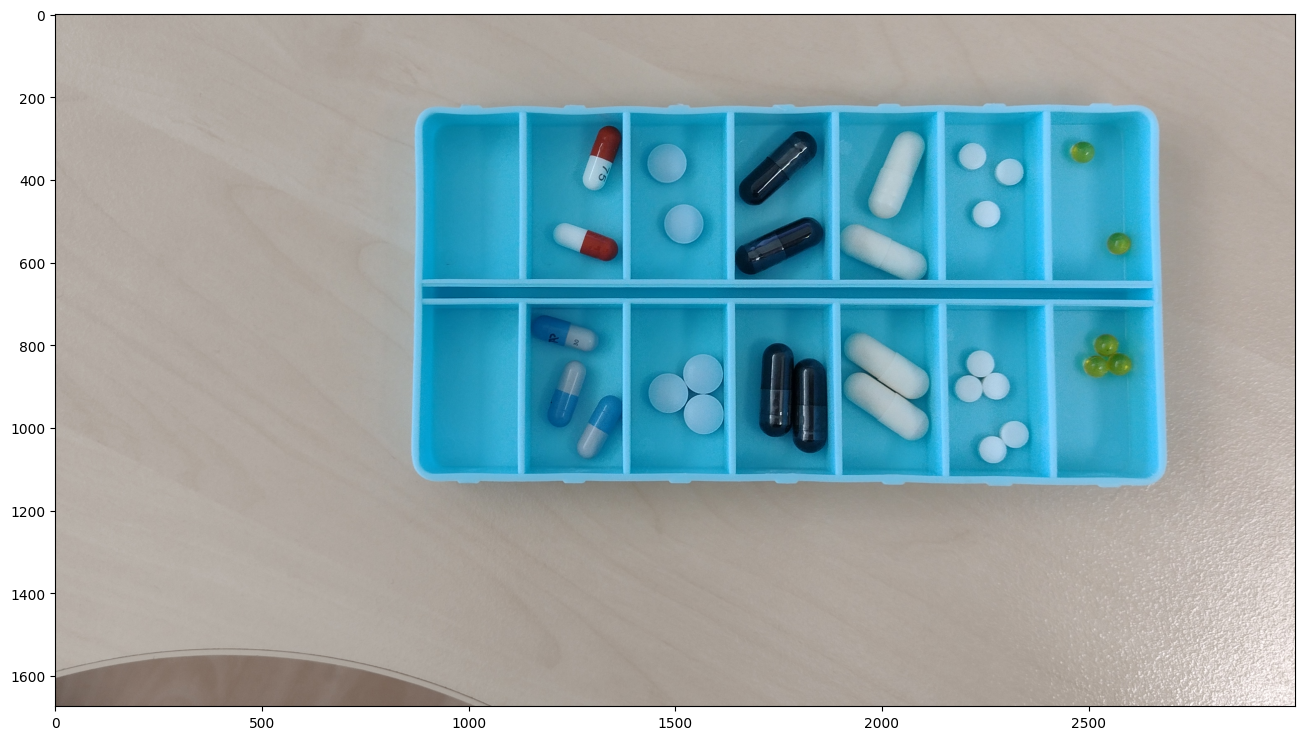

In [2]:
calib = cv2.imread('Data/calib.png') # it reads in BGR fromat
plt.subplots(1, 1, figsize=(16,9))[1].imshow(calib[..., ::-1]);

In [3]:
show_unsuccesful_results = False

### Zadanie 1
Wykorzystując narzędzia poznane na poprzednich zajęciach (konwersja przestrzeni barw, detekcja krawędzi, binaryzacja, etc.) oraz [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0), zaproponuj algorytm detekcji obiektów (funkcja `detect_objects`).
Poprawnie działający algorytm powinien zwracać listę konturów lub bounding boksów reprezentujących poszczególne obiekty
(czy nawet dowolnych obiektów zawierających jedno i drugie).

W zależności od przyjętego podejścia, doimplementuj metodę `display_objects`, by wyświetlić rezultaty.

Podpowiedzi:
* zacznij od górnego wiersza, z pominięciem dwukolorowych kapsułek
* w drugiej kolejności podejmij problem stykających się obiektów
* dwukolorowe kapsułki są "dla ambitnych"

### Rozwiązanie

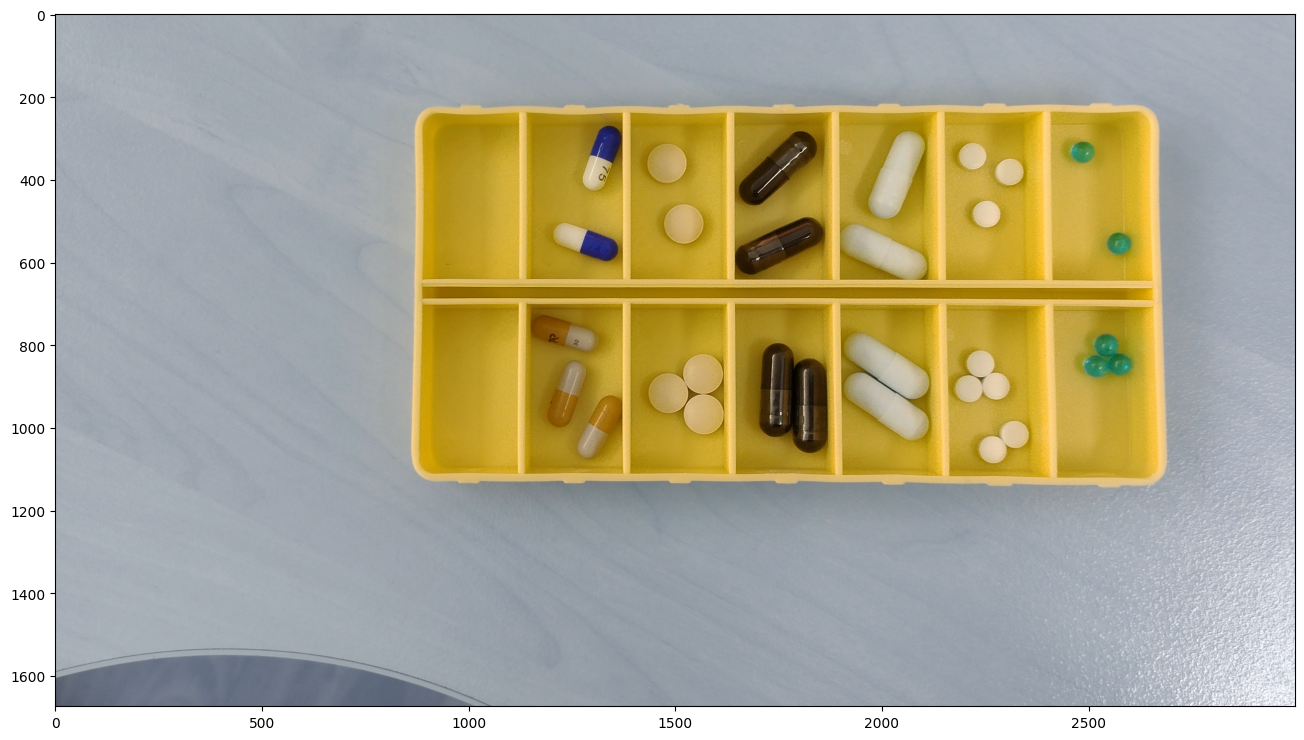

In [4]:
img = cv2.cvtColor(calib, cv2.COLOR_RGB2HSV)#calib[..., ::-1]
# lower = np.array([0,0,100])
# upper = np.array([95,255,250])
# lower = np.array([19, 138, 174])
# upper = np.array([114, 194, 231])
lower = np.array([90, 115, 100])
upper = np.array([110, 255, 255])
#     'darkblue': (200, 94, 63),
# lower = np.array([190,93,61])
# upper = np.array([195,97,68])

# Create mask to only select black
# thresh = cv2.inRange(img, lower, upper)
mask = cv2.inRange(img, lower, upper)

# apply morphology
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
# morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# invert morp image
mask = 255 - mask

# apply mask to image
img = cv2.bitwise_and(calib.copy(), calib.copy(), mask=mask)

plt.subplots(1, 1, figsize=(16,9))[1].imshow(img);

In [5]:
# img = calib#cv2.cvtColor(calib, cv2.COLOR_BGR2RGB)#calib[..., ::-1]
# # lower = np.array([0,0,100])
# # upper = np.array([95,255,250])
# # lower = np.array([19, 138, 174])
# # upper = np.array([114, 194, 231])

# lower = np.array([0, 0, 90])
# upper = np.array([110, 255, 255])


# # lower = np.array([190,93,61])
# # upper = np.array([195,97,68])

# # Create mask to only select black
# # thresh = cv2.inRange(img, lower, upper)
# mask = cv2.inRange(img, lower, upper)

# # apply morphology
# # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
# # morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# # invert morp image
# mask = 255 - mask

# # apply mask to image
# img = cv2.bitwise_and(img, img, mask=mask)

# plt.subplots(1, 1, figsize=(16,9))[1].imshow(img);

In [6]:
calib = cv2.cvtColor(calib, cv2.COLOR_BGR2RGB)#calib[..., ::-1]

In [7]:
def get_contours(image, contours_type, min_area=-1, max_area=-1):
    contours, hierarchy = cv2.findContours(image, contours_type, method=cv2.CHAIN_APPROX_NONE)
    if min_area > 0:
        contours = [c for c in contours if cv2.contourArea(c) >= min_area] 
    if max_area > 0:
        contours = [c for c in contours if max_area >= cv2.contourArea(c)] 
        
    return contours

def get_image_for_contours_finding(img, contours_transformation):
    img = contours_transformation['gray'](img)
    img = contours_transformation['threshold'](img)
    return img

In [8]:
def plot_img(img, title, with_contours=False, contours_transformation=None, contours_args=None):
    if with_contours:
        fig, ax = plt.subplots(1, 2, figsize=(14,4))
        ax[0].imshow(img, cmap='gray');
        
        img = contours_transformation['gray'](img)
        img = contours_transformation['threshold'](img)
        contours = get_contours(img, **contours_args)
        contours_img = np.zeros_like(img)
        cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)

        ax[1].imshow(contours_img, cmap='gray');
        
        plt.title(title)
        ax[1].set_title(f'Contours. Contours number: {len(contours)}')
        #plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 4))
        plt.imshow(img, cmap='gray');
        plt.title(title)
        #plt.tight_layout()
        plt.show()

Pierwsze zastosowane podejście polegało na zastosowaniu prostych transformacji obrazu, a następnie próbie wydzielenia konturów z całego obrazu.

In [9]:
def morphology(img):
    eroded = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    opened = cv2.dilate(eroded, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE)
    return opened

In [10]:
default_contours_args = {
    'contours_type': cv2.RETR_EXTERNAL,
    'min_area': -1,
    'max_area': -1
}

def detect_objects_configurable(image:np.ndarray,
                                plot_with_contours=False, 
                                contours_transformation=None,
                                contours_args=None,
                                **kwargs):
    plot_img(image, title='Basic', 
         with_contours=plot_with_contours, 
         contours_transformation=contours_transformation, 
         contours_args=contours_args)
    
    for name, transformation in kwargs.items():
        if name.startswith('trans'):
            image = transformation(image)
            plot_img(image, title=name, 
                     with_contours=plot_with_contours, 
                     contours_transformation=contours_transformation, 
                     contours_args=contours_args)
    
    image = get_image_for_contours_finding(image, contours_transformation)
    contours = get_contours(image, **contours_args)
    print('Liczba konturow: ', len(contours))
    display = np.zeros_like(image)
    cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    plot_img(display, 'Kontury')
    
    return contours

In [11]:
if show_unsuccesful_results:
    filter_matrix = np.array([[1, -1, 1], 
        [-1, 9, -1], 
        [1, -1, 1]])
    filter_matrix = filter_matrix/filter_matrix.sum() 

    filter_matrix_2 = np.array([[1, 2, 1], 
            [2, 4, 2], 
            [1, 2, 1]])
    filter_matrix_2 = filter_matrix/filter_matrix.sum() 

    kernel = np.ones((3, 3), dtype=np.uint8)

    contours = detect_objects_configurable(calib,
        trans_sharp1=lambda x: cv2.filter2D(x, -1, filter_matrix),
        trans_sharp2=lambda x: cv2.filter2D(x, -1, filter_matrix),
        trans_median_blur=lambda x: cv2.medianBlur(x, 7), 
        trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=1),
    #   trans_morph=lambda x: morphology(x),
    #   trans_morfo3=lambda x: morfologia(x),
        #trans_wyostrzyj3=lambda x: cv2.filter2D(x, -1, filter_matrix),
        #trans_hsv=lambda x: hsv_transform(x, threshold_h=-1, threshold_s=115, threshold_v=128),
        #trans_eroded=lambda x: cv2.erode(x, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=3),
        #trans_gray_lab=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2LAB)[..., 1],
        trans_sharp3=lambda x: cv2.filter2D(x, -1, filter_matrix),
        #transdsdsd=lambda x: cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 7),
        #
        #trans01=lambda x: cv2.filter2D(x, -1, filter_matrix),
        #trans_hsv=lambda x: hsv_transform(x, threshold_h=-1, threshold_s=-1, threshold_v=-1),
        #trans_bilateral=lambda x: cv2.bilateralFilter(x, 9, 65, 75),
        #trans_median_blur=lambda x: cv2.medianBlur(x, 7), 
        #trans_otsu=lambda x: sliding_window_otsu(x, 100),
        #trans_adaptive=lambda x: cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 7, 2),
        contours_transformation={
            'gray': lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),
            'threshold': lambda x: cv2.Canny(image=x, threshold1=50, threshold2=180)},
        contours_args=default_contours_args,
        plot_with_contours=True
        #max_contours_area=400,
    )

In [12]:
kernel = np.ones((3, 3), dtype=np.uint8)

In [13]:
def hsv_transform(image, threshold_h=20, threshold_s=160, threshold_v=110):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(img_hsv)

    if threshold_h != -1:
        (T, result_h) = cv2.threshold(h, threshold_h, 255, cv2.THRESH_BINARY_INV)
    else:
        result_h = h
    if threshold_s != -1:
        (T, result_s) = cv2.threshold(s, threshold_s, 255, cv2.THRESH_BINARY_INV)
    else:
        result_s = s
    if threshold_v != -1:
        (T, result_v) = cv2.threshold(v, threshold_v, 255, cv2.THRESH_BINARY_INV)
    else:
        result_v = v

    result = cv2.merge([result_h, result_s, result_v])
    return result

Próbowano również podejścia interaktywnego w celu sprawniejszej selekcji wartości parametrów.

In [14]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def detect_objects_interactive(filename, erode_iterations, threshold_h, threshold_s, threshold_v, binarizer_selector, canny_threshold1, canny_threshold2):
    img = cv2.imread(filename)
    #img = calib[y1:y2, x1:x2]
    img = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=erode_iterations)
    img = hsv_transform(img, threshold_h=threshold_h, threshold_s=threshold_s, threshold_v=threshold_v)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if binarizer_selector == 'canny':
        img = cv2.Canny(img, threshold1=canny_threshold1, threshold2=canny_threshold2)
    elif binarizer_selector == 'sobel':
        img = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=canny_threshold1)
    elif binarizer_selector == 'adaptive':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, canny_threshold1, canny_threshold2),
    plot_img(img, '')

    contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    display = np.zeros_like(img)
    cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    plot_img(display, 'Kontury')

if show_unsuccesful_results:
    interact(detect_objects_interactive,
                filename=widgets.Dropdown(options=['Data/calib.png', 'Data/test1.png', 'Data/test2.png', 'Data/test3.png']),
                erode_iterations=widgets.IntSlider(min=0, max=50, step=1, value=1),
                threshold_h=widgets.IntSlider(min=1, max=250, step=1, value=20),
                threshold_s=widgets.IntSlider(min=1, max=200, step=1, value=100),
                threshold_v=widgets.IntSlider(min=1, max=200, step=1, value=100),
                binarizer_selector=widgets.Dropdown(options=['canny', 'sobel', 'adaptive']),
                canny_threshold1=widgets.IntSlider(min=0, max=500, step=1, value=1),
                canny_threshold2=widgets.IntSlider(min=0, max=500, step=1, value=255),
            );


Zastosowane podejścia okazały się jednak bardzo trudne w skutecznym wyegzekwowaniu. W związku z tym zdecydowano się na wydzielenie komórek pojemnika korzystając z transformacji Hougha. 

In [15]:
def rhotheta2xy(line):
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

def get_hough_lines(img, canny_threshold1, canny_threshold2, hl_rho, hl_theta, hl_threshold, show):
    img_filtered = cv2.medianBlur(img, 13)
    canny_img = cv2.Canny(image=img_filtered, threshold1=canny_threshold1, threshold2=canny_threshold2)
    lines = cv2.HoughLines(canny_img, rho=hl_rho, theta=hl_theta, threshold=hl_threshold)

    img_to_show = img.copy()
    
    if show:
        for line in lines:
            x1, y1, x2, y2 = rhotheta2xy(line)
            cv2.line(img_to_show, (x1,y1), (x2,y2), (255,0,0), 2)
        plt.imshow(img_to_show)
        plt.show()
    return lines

In [16]:
if show_unsuccesful_results:
    hough_lines = get_hough_lines(calib, 
        canny_threshold1=40, 
        canny_threshold2=140, 
        hl_rho=3, 
        hl_theta=0.5*(np.pi/180), 
        hl_threshold=560,
        show=False)

    image_lines = calib.copy()
    for line in hough_lines:
        x1, y1, x2, y2 = rhotheta2xy(line)
        cv2.line(image_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(image_lines)

In [17]:
if show_unsuccesful_results:
    print(hough_lines.shape)
    hough_lines = np.reshape(hough_lines, (-1, 2))
    print(hough_lines.shape)

In [18]:
if show_unsuccesful_results:
    lines_angles = [np.pi/2 + line[1] for line in hough_lines]

In [19]:
if show_unsuccesful_results:
    pi_diff = np.pi/18
    lines_horizontal = [line for i, line in enumerate(hough_lines) if -pi_diff < abs(lines_angles[i]) < pi_diff or np.pi - pi_diff < abs(lines_angles[i]) < np.pi + pi_diff ]
    lines_vertical = [line for i, line in enumerate(hough_lines) if (np.pi/2) - pi_diff < abs(lines_angles[i]) < (np.pi/2) + pi_diff or (3 * np.pi/2) - pi_diff < abs(lines_angles[i]) <  (3 * np.pi/2) + pi_diff ]

In [20]:
# https://stackoverflow.com/questions/46565975/find-intersection-point-of-two-lines-drawn-using-houghlines-opencv
def hough_intersection(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    return np.linalg.lstsq(A, b)[0]

In [21]:
if show_unsuccesful_results:
    boxes_crosses = []
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    lines_img = calib.copy()
    for (rho_1, theta_1) in lines_vertical:
        for (rho_2, theta_2) in lines_horizontal:
            if (rho_1, theta_1) != (rho_2, theta_2):
                x, y = hough_intersection(theta_1, rho_1, theta_2, rho_2)
                boxes_crosses.append((x, y))
                if 0 < x < calib.shape[1] and 0 < y < calib.shape[0]:
                    lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

    major_ticks_x = np.arange(0, calib.shape[1], 200)
    major_ticks_y = np.arange(0, calib.shape[0], 200)
    ax.set_xticks(major_ticks_x)
    ax.set_yticks(major_ticks_y)
    ax.imshow(lines_img)

In [22]:
# box_approx_width = 300
# box_approx_height = 450
# boxes_rectangles = []

# lines_img = calib.copy()
# for (x1, y1) in boxes_crosses:
#     for (x2, y2) in boxes_crosses:
#         if (x1, y1) != (x2, y2):
#             box_width = x2 - x1
#             box_height = y2 - y1
#             if abs(box_width - box_approx_width) < 70 and abs(box_height - box_approx_height) < 70:
#                 lines_img = cv2.rectangle(lines_img, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=2)
#                 boxes_rectangles.append([int(x1), int(y1), int(x2), int(y2)])

# plt.imshow(lines_img)

In [23]:
if show_unsuccesful_results:
    print(len(boxes_crosses))
    kmeans = KMeans(n_clusters=8*3, random_state=0, n_init='auto').fit(boxes_crosses)
    clusters = kmeans.predict(boxes_crosses)

    final_boxes_crosses_dict = collections.defaultdict(list)

    for index, cl in enumerate(clusters):
        final_boxes_crosses_dict[cl].append(boxes_crosses[index])

    final_boxes_crosses = [tuple(map(np.mean, zip(*x))) for x in final_boxes_crosses_dict.values()]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    dots_img = calib.copy()
    for x, y in final_boxes_crosses:
        if 0 < x < calib.shape[1] and 0 < y < calib.shape[0]:
            dots_img = cv2.circle(dots_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

    major_ticks_x = np.arange(0, calib.shape[1], 200)
    major_ticks_y = np.arange(0, calib.shape[0], 200)
    ax.set_xticks(major_ticks_x)
    ax.set_yticks(major_ticks_y)
    ax.imshow(dots_img)

In [24]:
if show_unsuccesful_results:
    print(final_boxes_crosses)

In [25]:
if show_unsuccesful_results:
    # final_boxes_crosses = sorted(final_boxes_crosses, key=lambda x: (x[1], x[0]), reverse=False)
    final_boxes_crosses = sorted(final_boxes_crosses, key=lambda x: (4 * x[0] + x[1]), reverse=False)
    print(final_boxes_crosses[0])

In [26]:
if show_unsuccesful_results:
    cells_points = []

    for i in range(len(final_boxes_crosses)-4):
        if i%3 == 2:
            continue
        p1 = final_boxes_crosses[i]
        p2 = final_boxes_crosses[4 + i]
        cells_points.append((p1, p2))

In [27]:
if show_unsuccesful_results:
    cells_points = [ ((int(x[0]), int(x[1])), (int(y[0]), int(y[1]))) for x, y in cells_points]

In [28]:
if show_unsuccesful_results:
    cells_points

In [29]:
if show_unsuccesful_results:
    for p1, p2 in cells_points:
        x1 = min(p1[0], p2[0])
        x2 = max(p1[0], p2[0])
        y1 = min(p1[1], p2[1])
        y2 = max(p1[1], p2[1])
        print(y1, y2, x1, x2)
        plt.imshow(calib[y1:y2, x1:x2])
        plt.show()

### Ostateczne rozwiązanie

In [30]:
def get_box_cells(img, debug_plot=False):
    hough_lines = get_hough_lines(img, 
        canny_threshold1=60, 
        canny_threshold2=140, 
        hl_rho=3, 
        hl_theta=0.5*(np.pi/180), 
        hl_threshold=560,
        show=False)

    if debug_plot:
        image_lines = img.copy()
        for line in hough_lines:
            x1, y1, x2, y2 = rhotheta2xy(line)
            cv2.line(image_lines, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.imshow(image_lines)

    hough_lines = np.reshape(hough_lines, (-1, 2))
    lines_angles = [np.pi/2 + line[1] for line in hough_lines]
    pi_diff = np.pi/18
    lines_horizontal = [line for i, line in enumerate(hough_lines) if -pi_diff < abs(lines_angles[i]) < pi_diff or np.pi - pi_diff < abs(lines_angles[i]) < np.pi + pi_diff ]
    lines_vertical = [line for i, line in enumerate(hough_lines) if (np.pi/2) - pi_diff < abs(lines_angles[i]) < (np.pi/2) + pi_diff or (3 * np.pi/2) - pi_diff < abs(lines_angles[i]) <  (3 * np.pi/2) + pi_diff ]

    boxes_crosses = []
    if debug_plot:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

    if debug_plot:
        lines_img = img.copy()
    for (rho_1, theta_1) in lines_vertical:
        for (rho_2, theta_2) in lines_horizontal:
            if (rho_1, theta_1) != (rho_2, theta_2):
                x, y = hough_intersection(theta_1, rho_1, theta_2, rho_2)
                boxes_crosses.append((x, y))
                if debug_plot:
                    if 0 < x < img.shape[1] and 0 < y < img.shape[0]:
                        lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

    if debug_plot:
        major_ticks_x = np.arange(0, img.shape[1], 200)
        major_ticks_y = np.arange(0, img.shape[0], 200)
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.imshow(lines_img)


    kmeans = KMeans(n_clusters=8*3, random_state=0, n_init='auto').fit(boxes_crosses)
    clusters = kmeans.predict(boxes_crosses)

    final_boxes_crosses_dict = collections.defaultdict(list)

    for index, cl in enumerate(clusters):
        final_boxes_crosses_dict[cl].append(boxes_crosses[index])

    final_boxes_crosses = [tuple(map(np.mean, zip(*x))) for x in final_boxes_crosses_dict.values()]

    if debug_plot:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        lines_img = img.copy()
        for x, y in final_boxes_crosses:
            if 0 < x < img.shape[1] and 0 < y < img.shape[0]:
                lines_img = cv2.circle(lines_img, (int(x), int(y)), radius=10, color=(255, 0, 0), thickness=-1)

        major_ticks_x = np.arange(0, img.shape[1], 200)
        major_ticks_y = np.arange(0, img.shape[0], 200)
        ax.set_xticks(major_ticks_x)
        ax.set_yticks(major_ticks_y)
        ax.imshow(lines_img)

    final_boxes_crosses = sorted(final_boxes_crosses, key=lambda x: (4 * x[0] + x[1]), reverse=False)
    cells_points = []

    for i in range(len(final_boxes_crosses)-4):
        if i%3 == 2:
            continue
        p1 = final_boxes_crosses[i]
        p2 = final_boxes_crosses[4 + i]
        cells_points.append((p1, p2))

    cells_points = [ ((int(x[0]), int(x[1])), (int(y[0]), int(y[1]))) for x, y in cells_points]

    return cells_points

In [31]:
def show_cells(img, cells_points):
    for p1, p2 in cells_points:
        x1 = min(p1[0], p2[0])
        x2 = max(p1[0], p2[0])
        y1 = min(p1[1], p2[1])
        y2 = max(p1[1], p2[1])
        print(x1, y1, x2, y2)
        plt.imshow(calib[y1:y2, x1:x2])
        plt.show()

In [32]:
def get_cell(img, cells_points, i):
    p1, p2 = cells_points[i]
    x1 = min(p1[0], p2[0])
    x2 = max(p1[0], p2[0])
    y1 = min(p1[1], p2[1])
    y2 = max(p1[1], p2[1])
    return img[y1:y2, x1:x2], x1, y1

In [33]:
cells = get_box_cells(calib, False)

/tmp/ipykernel_29257/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


In [34]:
def plot_img(img, title, with_contours=False, contours_transformation=None, contours_args=None):
    if with_contours:
        fig, ax = plt.subplots(1, 2, figsize=(14,4))
        ax[0].imshow(img, cmap='gray');
        
        img = contours_transformation['gray'](img)
        img = contours_transformation['threshold'](img)
        contours = get_contours(img, **contours_args)
        contours_img = np.zeros_like(img)
        cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)

        ax[1].imshow(contours_img, cmap='gray');
        
        plt.title(title)
        ax[1].set_title(f'Contours. Contours number: {len(contours)}')
        #plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 4))
        plt.imshow(img, cmap='gray');
        plt.title(title)
        #plt.tight_layout()
        plt.show()

In [126]:
def ret_x(x):
    return x

def detect_objects_cells(cell_id, erode_iterations, 
        dilate_iterations, 
        median_blur,
        low_h, low_s, low_v,
        high_h, high_s, high_v,
        # threshold_h, threshold_s, threshold_v, 
        min_area, max_area,
        binarizer_selector, canny_threshold1, canny_threshold2):
    fig, ax = plt.subplots(1, 6, figsize=(15, 4))
    img, _, _ = get_cell(calib, cells, cell_id)#[..., ::-1]

    contours_args = {
        'contours_type': cv2.RETR_EXTERNAL,#TREE,#EXTERNAL,
        'min_area': min_area,
        'max_area': max_area
    }
    # STARE, ALE JARE:
    # lower = np.array([low_r, low_g, low_b])
    # upper = np.array([high_r, high_g, high_b])

    # # Create mask to only select no blue
    # thresh = cv2.inRange(img, lower, upper)

    # # apply morphology
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
    # morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # # invert morp image
    # mask = 255 - morph

    # # apply mask to image
    # img = cv2.bitwise_and(img, img, mask=mask)

    # NOWE:
    calib[..., ::-1]
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2HSV)
    lower = np.array([low_h, low_s, low_v])
    upper = np.array([high_h, high_s, high_v])
    mask = cv2.inRange(img_hsv, lower, upper)
    # apply morphology
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
#     morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # invert morp image
    mask = 255 - mask
    img = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    xx = 0
    ax[xx].imshow(img)
    ax[xx].set_title('basic')
    xx += 1

    kernel = np.ones((5, 5), dtype=np.uint8)
    img = cv2.erode(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=erode_iterations)
    ax[xx].imshow(img)
    ax[xx].set_title('erode')
    xx += 1
    
    img = cv2.dilate(img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=dilate_iterations)
    ax[xx].imshow(img)
    ax[xx].set_title('dilate')
    xx += 1
    
    img = cv2.medianBlur(img, median_blur) 
    ax[xx].imshow(img)
    ax[xx].set_title('median blur')
    xx += 1

    #img = hsv_transform(img, threshold_h=threshold_h, threshold_s=threshold_s, threshold_v=threshold_v)
    # ax[2].imshow(img)
    # ax[2].set_title('hsv')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if binarizer_selector == 'canny':
        img = cv2.Canny(img, threshold1=canny_threshold1, threshold2=canny_threshold2)
    elif binarizer_selector == 'sobel':
        img = cv2.Sobel(img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=canny_threshold1)
    elif binarizer_selector == 'adaptive':
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, canny_threshold1, canny_threshold2),
    
    contours_transformation={
        'gray': lambda x: ret_x(x),
        'threshold': lambda x: ret_x(x)
        }

    ax[4].imshow(img)
    ax[4].set_title('threshold')
    # plt.show()
    contours = get_contours(img, **contours_args)
    contours_img = np.zeros_like(img)
    cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)
    #fig, ax = plt.subplots(figsize=(8, 4))
    ax[5].imshow(contours_img, cmap='gray');
    ax[5].set_title(f'Contours. Contours number: {len(contours)}')
    # contours, hierarchy = cv2.findContours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    # display = np.zeros_like(img)
    # cv2.drawContours(display, contours, -1, (255, 255, 0), 3)
    # #plot_img(display, 'Kontury', True, contours_transformation, contours_args=contours_args)

interact(detect_objects_cells,
            cell_id=widgets.IntSlider(min=0, max=len(cells)-1, step=1, value=5),
            erode_iterations=widgets.IntSlider(min=0, max=50, step=1, value=8),
            dilate_iterations=widgets.IntSlider(min=0, max=50, step=1, value=3),
            median_blur=widgets.IntSlider(min=1, max=21, step=2, value=5),
            low_h=widgets.IntSlider(min=1, max=255, step=1, value=90),
            low_s=widgets.IntSlider(min=1, max=255, step=1, value=159),
            low_v=widgets.IntSlider(min=1, max=255, step=1, value=100),
            high_h=widgets.IntSlider(min=1, max=255, step=1, value=99),
            high_s=widgets.IntSlider(min=1, max=255, step=1, value=255),
            high_v=widgets.IntSlider(min=1, max=255, step=1, value=255),
            # low_r=widgets.IntSlider(min=1, max=255, step=1, value=0),
            # low_g=widgets.IntSlider(min=1, max=255, step=1, value=0),
            # low_b=widgets.IntSlider(min=1, max=255, step=1, value=100),
            # high_r=widgets.IntSlider(min=1, max=255, step=1, value=95),
            # high_g=widgets.IntSlider(min=1, max=255, step=1, value=255),
            # high_b=widgets.IntSlider(min=1, max=255, step=1, value=250),
            # threshold_h=widgets.IntSlider(min=-1, max=250, step=1, value=20),
            # threshold_s=widgets.IntSlider(min=-1, max=200, step=1, value=100),
            # threshold_v=widgets.IntSlider(min=-1, max=200, step=1, value=100),
            binarizer_selector=widgets.Dropdown(options=['canny', 'sobel', 'adaptive']),
            canny_threshold1=widgets.IntSlider(min=0, max=900, step=1, value=20),
            canny_threshold2=widgets.IntSlider(min=0, max=900, step=1, value=140),
            min_area=widgets.IntSlider(min=-1, max=1000, step=1, value=15),
            max_area=widgets.IntSlider(min=-1, max=1000, step=1, value=-1))

interactive(children=(IntSlider(value=5, description='cell_id', max=13), IntSlider(value=8, description='erode…

<function __main__.detect_objects_cells(cell_id, erode_iterations, dilate_iterations, median_blur, low_h, low_s, low_v, high_h, high_s, high_v, min_area, max_area, binarizer_selector, canny_threshold1, canny_threshold2)>

In [36]:
# OKRAGLE ZROB HOUGHEM DO OKRAGLYCH

In [118]:
def find_contours_of_pills(img, contours_args=default_contours_args,
        erode_iterations=8, 
        dilate_iterations=3, 
        median_blur=5,
        low_h=90, low_s=159, low_v=100,
        high_h=99, high_s=255, high_v=255,
        binarizer_selector='canny', canny_threshold1=20, canny_threshold2=140):

    cells = get_box_cells(img, False)
    result_contours = []
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2HSV)

    lower = np.array([low_h, low_s, low_v])
    upper = np.array([high_h, high_s, high_v])
    mask = cv2.inRange(img_hsv, lower, upper)
    # apply morphology
#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
#     morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # invert morp image
    mask = 255 - mask
    # apply mask to image
    img = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    
    for cell_id in range(len(cells)):
        fig, ax = plt.subplots(1, 6, figsize=(15, 4))
        cell_img, x_shift, y_shift = get_cell(img, cells, cell_id)#[..., ::-1]
        ax[0].imshow(cell_img)
        ax[0].set_title('basic')
        
        kernel = np.ones((5, 5), dtype=np.uint8) 
        cell_img = cv2.erode(cell_img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=erode_iterations)
        ax[1].imshow(cell_img)
        ax[1].set_title('erode')
        
        cell_img = cv2.dilate(cell_img, kernel=kernel, anchor=(-1,-1), borderType=cv2.BORDER_REPLICATE, iterations=dilate_iterations)
        ax[2].imshow(cell_img)
        ax[2].set_title('dilate')
        
        cell_img = cv2.medianBlur(cell_img, median_blur)
        ax[3].imshow(cell_img)
        ax[3].set_title('dilate')
        
        cell_img = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        if binarizer_selector == 'canny':
            cell_img = cv2.Canny(cell_img, threshold1=canny_threshold1, threshold2=canny_threshold2)
        elif binarizer_selector == 'sobel':
            cell_img = cv2.Sobel(cell_img, ddepth=cv2.CV_8U, dx=1, dy=1, ksize=canny_threshold1)
        elif binarizer_selector == 'adaptive':
            cell_img = cv2.adaptiveThreshold(cell_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, canny_threshold1, canny_threshold2),

        ax[4].imshow(cell_img)
        ax[4].set_title('threshold')
        contours = get_contours(cell_img, **contours_args)
        contours_img = np.zeros_like(cell_img)
        cv2.drawContours(contours_img, contours, -1, (255, 255, 0), 3)
        ax[5].imshow(contours_img, cmap='gray');
        ax[5].set_title(f'Contours. Contours number: {len(contours)}')

        plt.show()
        contours = [[(x+x_shift, y+y_shift) for x, y in np.vstack(contour).squeeze()] for contour in contours]
        print('Liczba konturow: ', len(contours))
        result_contours += contours

    result_contours = [np.array(x).reshape(-1, 1, 2) for x in result_contours]
    return result_contours

/tmp/ipykernel_29257/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


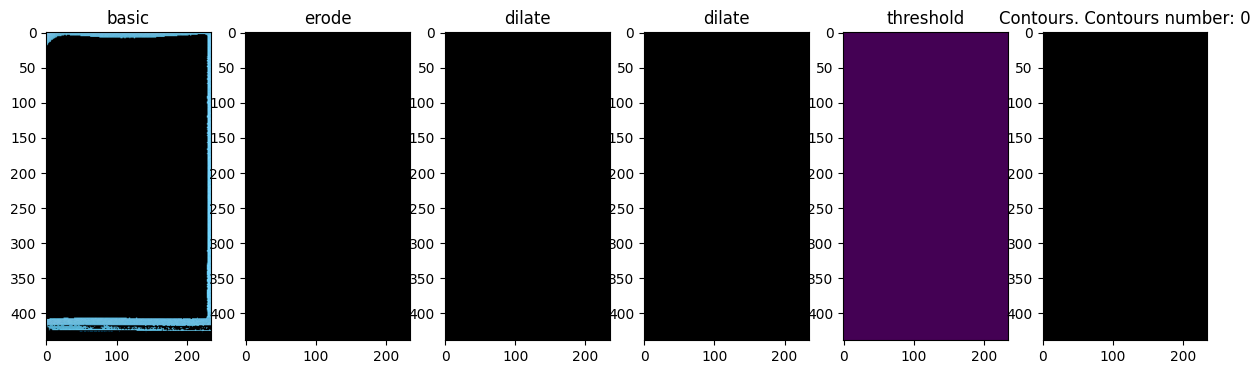

Liczba konturow:  0


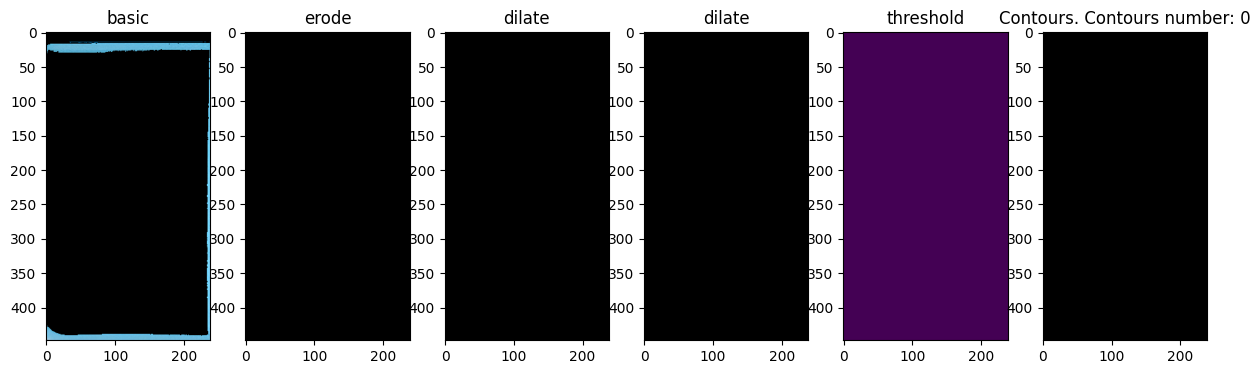

Liczba konturow:  0


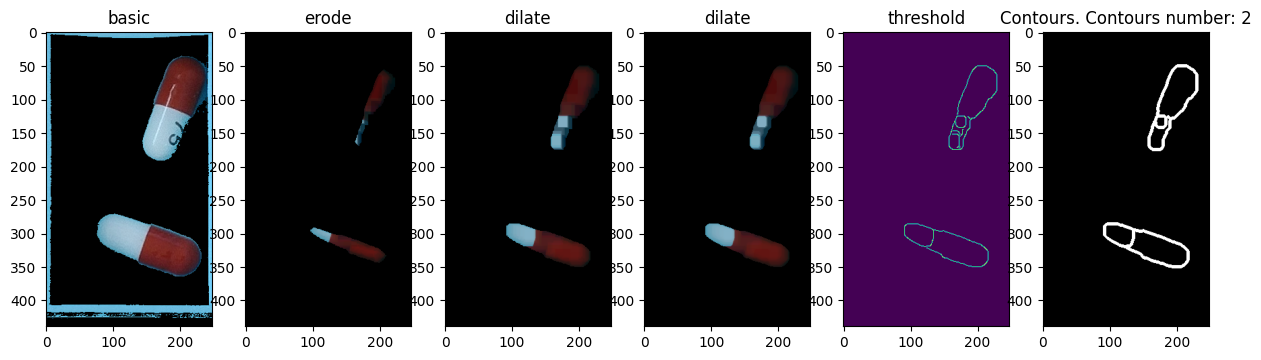

Liczba konturow:  2


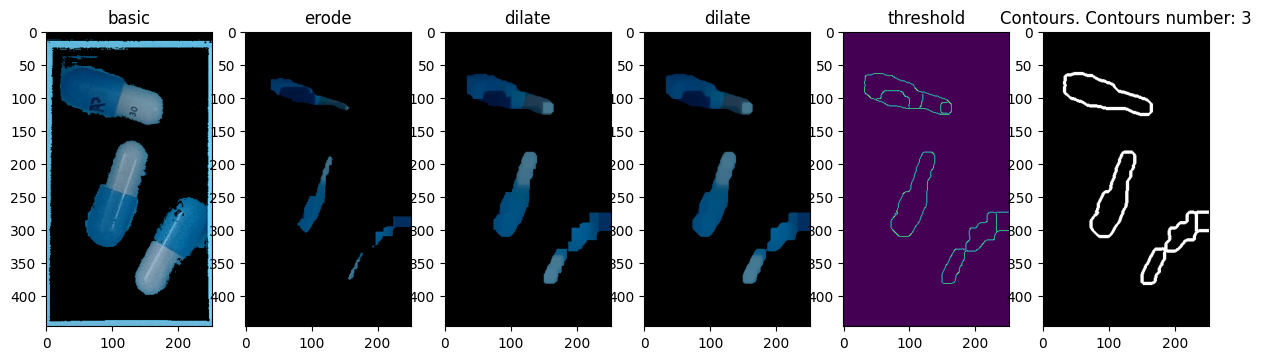

Liczba konturow:  3


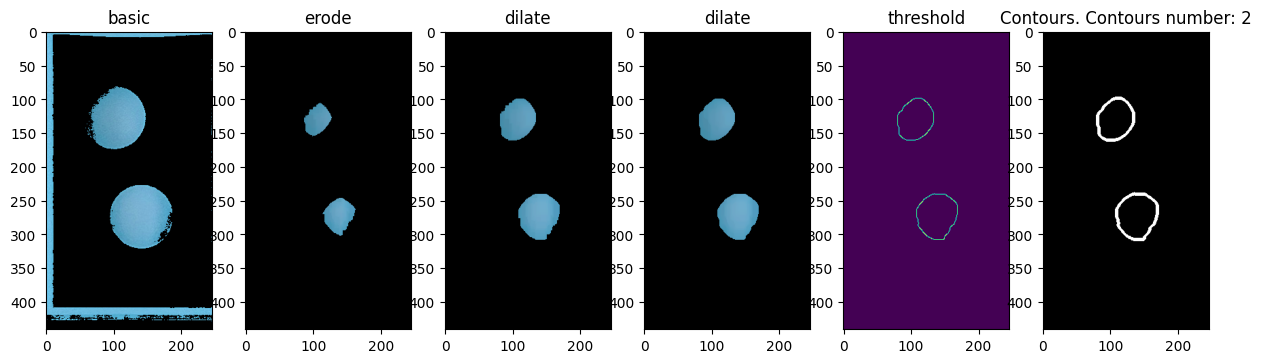

Liczba konturow:  2


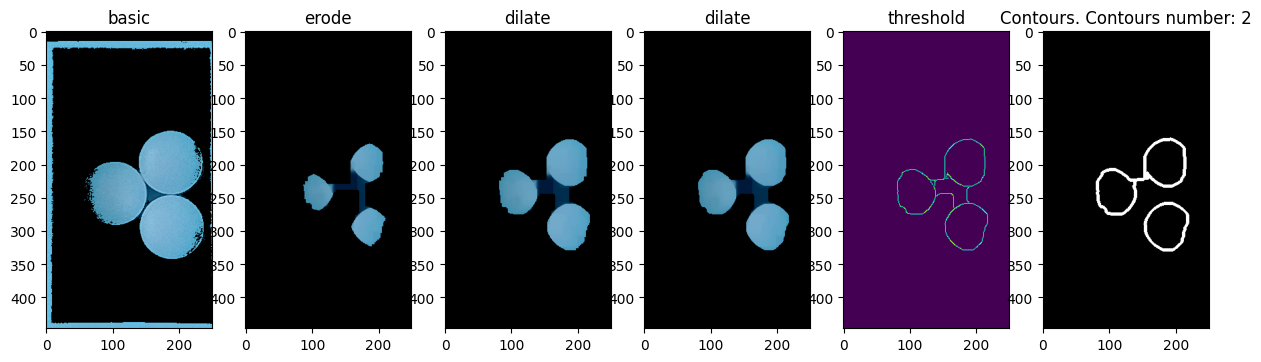

Liczba konturow:  2


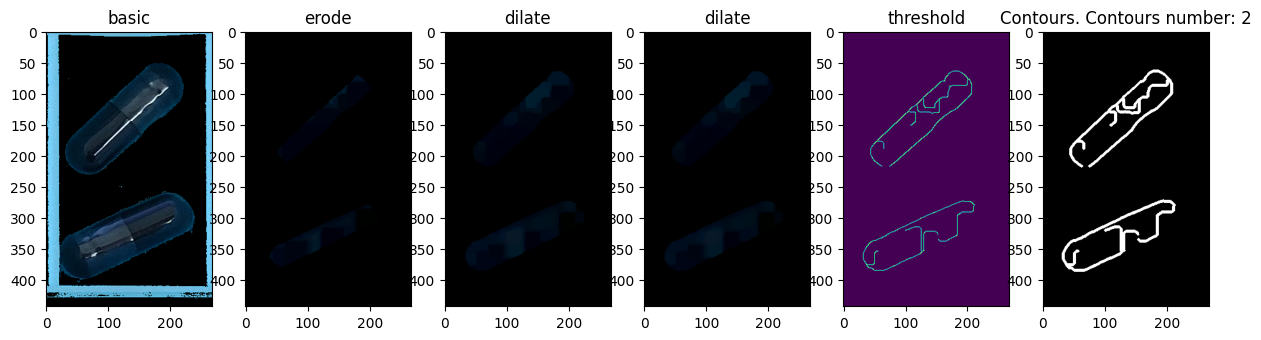

Liczba konturow:  2


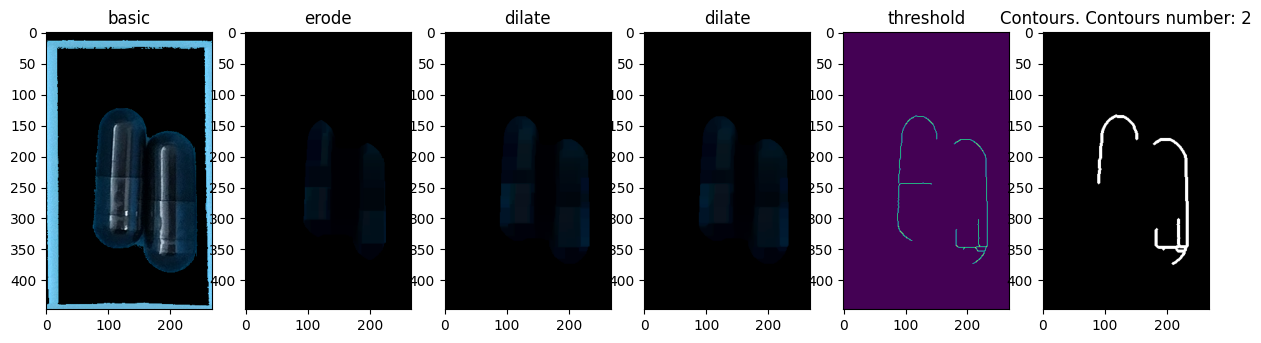

Liczba konturow:  2


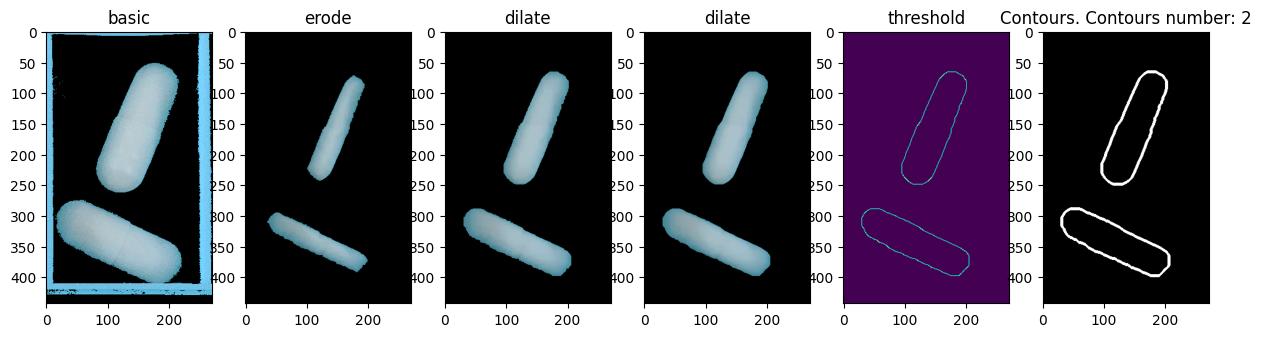

Liczba konturow:  2


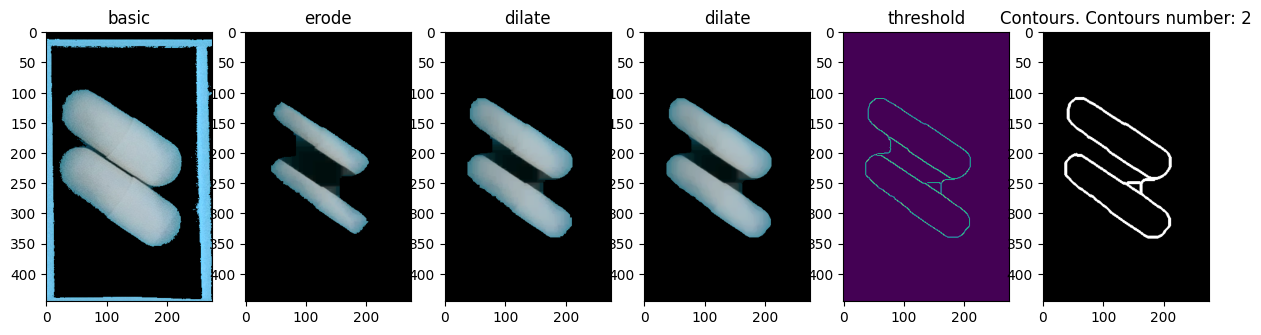

Liczba konturow:  2


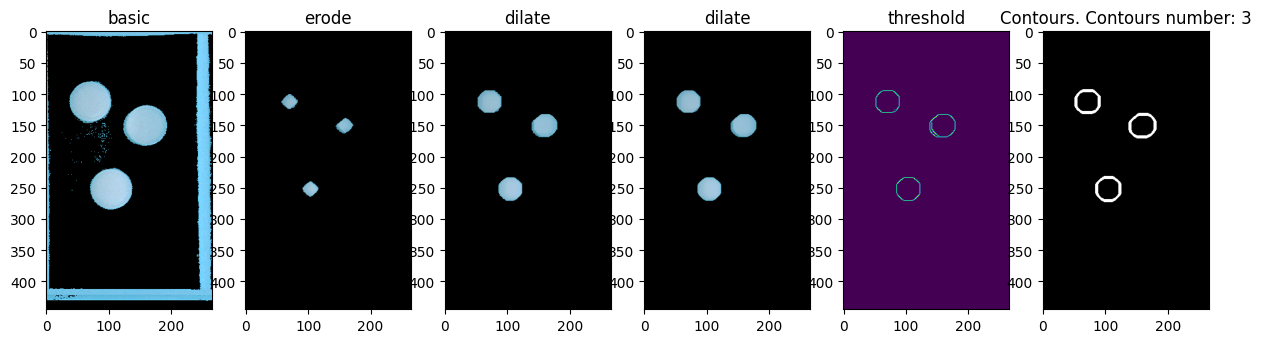

Liczba konturow:  3


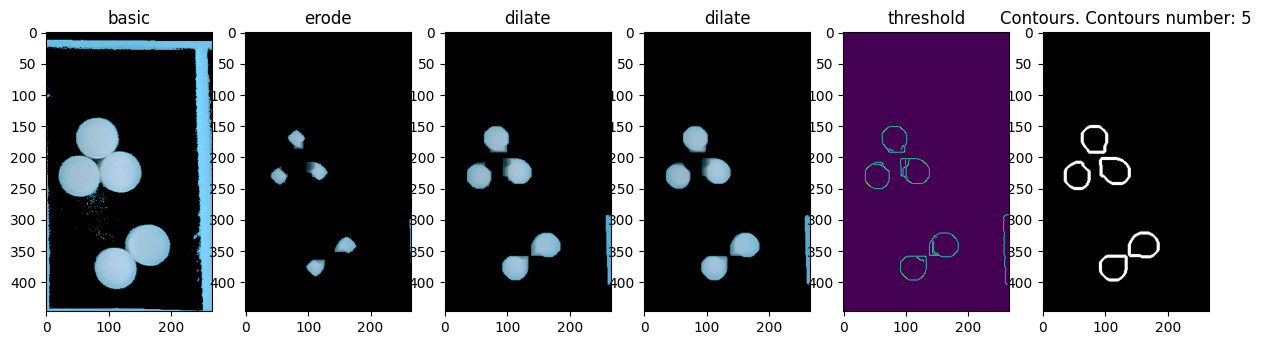

Liczba konturow:  5


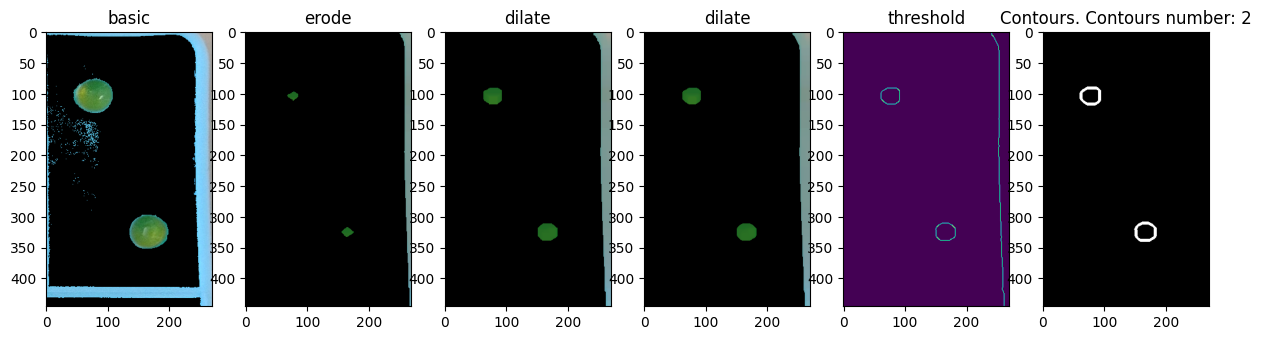

Liczba konturow:  2


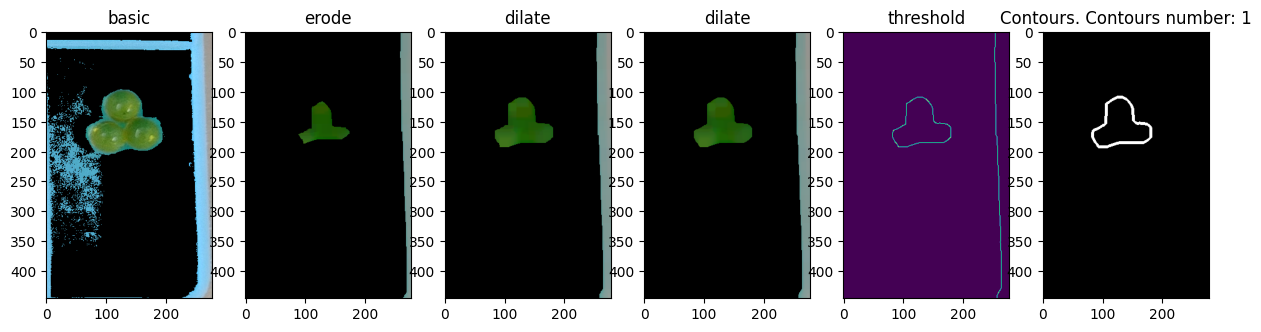

Liczba konturow:  1


In [170]:
contours_args = {
    'contours_type': cv2.RETR_EXTERNAL,
    'min_area': 15,
    'max_area': -1
}

contours = find_contours_of_pills(calib, contours_args)

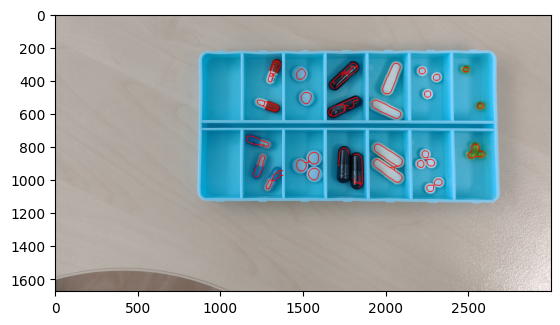

In [171]:
COLORS = [
  (255, 0, 0),
  (0, 255, 0),
  (0, 0, 255),
  (255, 255, 0),
  (255, 0, 255),
  (0, 255, 255),
]

def display_objects(image:np.ndarray, objects:List) -> None:
  image = image.copy()

  cv2.drawContours(image, objects, -1, (255, 0, 0), 3)
  plt.imshow(image)


display_objects(calib, contours)

### Zadanie 2
Dodaj do pipeline'u przetwarzania algorytm analizy obiektów, pozwalający na rozróżnienie obiektów poszczególnych klas.
Podejście jest zupełnie dowolne:
możesz zaimplementować go jako osobną procedurę (post-processing uzyskanych konturów) opartą o analizę kształtu i barwy,
możesz próbować zintegrować go z detekcją obiektów.
Obowiązuje tylko jedno zastrzeżenie: algorytm powinien być "klasyczny", tj. bez użycia uczenia maszynowego.

Jakkolwiek zdecydujesz, wyjściem algorytmu powinny być poetykietowane obiekty (kontur/bbox + etykieta).
Dodaj implementację funkcji `display_recognized` do rysowania wykrytych instancji;
skorzystaj z podanej mapy kolorów.

_Pro-tip do podejścia z post-processingiem konturów: zapoznaj się z metodami [zaawansowanego indeksowania macierzy](https://numpy.org/doc/stable/user/basics.indexing.html#advanced-indexing) w numpy, zwłaszcza indeksowaniem za pomocą macierzy binarnej. TL;DR: `obraz[maska]` powoduje odwołanie się tylko do tych pikseli obrazu `obraz`, które odpowiadają położeniem niezerowym pikselom maski._

In [172]:
COLORMAP = {
  'keto': (0, 0, 255), # RGB
  'carbon': (0, 0, 0),
  'probio': (255, 255, 255),
  'biox': (255, 0, 255),
  'espu': (255, 255, 0),
  'line': (255, 0, 0),
  'dexi': (127, 127, 127),
  'notidentified': (50, 150, 50)
}

PILLS_COLORS_RGB = {
    'white': (166, 197, 215),
    'darkblue': (10, 109, 161),
    'blue': (105, 166, 195),
    'green': (72, 136, 64),
    'black': (37, 51, 63),
    'red': (120, 42, 38)
}


PILLS_COLORS_HSV = {
    'white': (202, 23, 84),
    'darkblue': (200, 94, 63),
    'blue': (200, 44, 76),
    'green': (113, 53, 53),
    'black': (207, 47, 25),
    'red': (3, 68, 47)
}

PILLS_COLORS_HSV_FIXED = {
    'white': (100, 92, 200),
    'darkblue': (99, 136, 220),
    'blue': (99, 126, 204),
    'green': (55, 140, 132),
    'black': (102, 196, 58),
    'red': (90, 85, 180),
    'grey': (101, 86, 172)
}

1224 520 white [107.32348703  73.42002882 195.71325648] [ 0 16 75] [179 188 221]
1290 284 red [ 93.72379368  87.55906822 177.54908486] [ 0 16 38] [179 197 255]


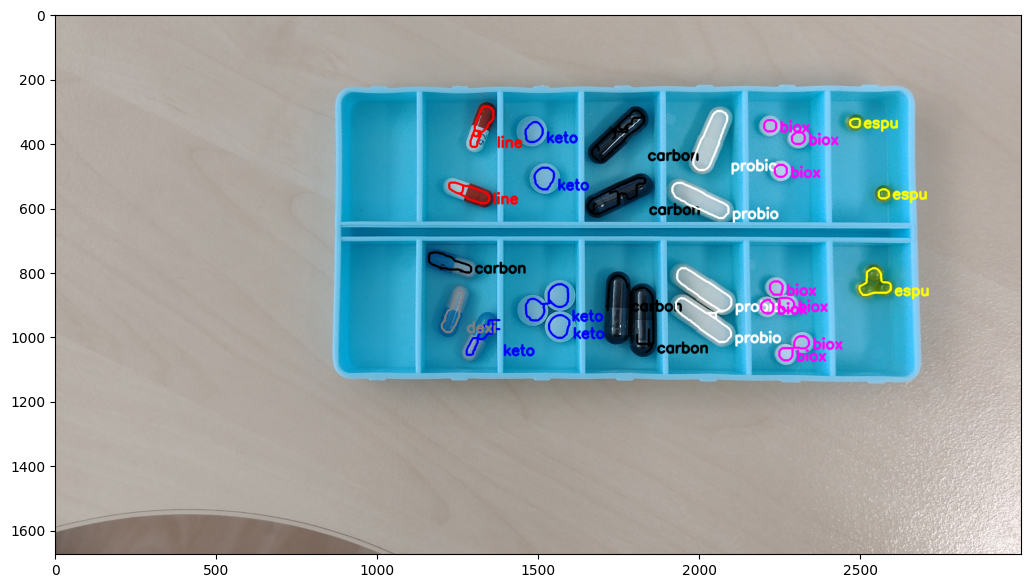

In [176]:
import scipy.ndimage as ndimage   

def get_recognized_pills(image:np.ndarray, objects:List):
    i = 0
    img_hsv = image.copy()
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    drawed_pills = image.copy()
    result = []

    for contour in objects:
        mask = np.zeros(img_hsv.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mask = mask.astype('float')
        mean_color = np.mean(img_hsv[~(mask == 0)], axis=0)
        
        threshold = 180
        assigned_color = None
        min_diff = 255 * 3

        for color_name, color_hsv in PILLS_COLORS_HSV_FIXED.items():
            color_diff = abs(mean_color - color_hsv).sum()

            if color_diff < threshold and color_diff < min_diff:
                assigned_color = color_name
                min_diff = color_diff
  
        if assigned_color is None:
            print('BRAK KOLORU')
            continue
        
        x, y, w, h = cv2.boundingRect(contour)
        # Oblicz stosunek długości do szerokości
        aspect_ratio = w / h
        if 1.22 > aspect_ratio > 0.82:
            pill_shape = 'circle'
        elif 5 > aspect_ratio > 0.2:
            pill_shape = 'longitudinal'
        else:
            continue

#         (x, y), radius = cv2.minEnclosingCircle(contour)
#         center = (int(x), int(y))
#         radius = int(radius)
#         ellipse = cv2.fitEllipse(contour)

#         contour_area = cv2.contourArea(contour)
#         circle_area = np.pi * radius**2
#         ellipse_area = ellipse[1][0] * ellipse[1][1] * np.pi

        # Sprawdź, czy kontur jest okręgiem lub elipsą
        # if abs(contour_area - circle_area) / contour_area < 0.5:
        #     shape = "circle"
        # elif abs(contour_area - ellipse_area) / contour_area < 0.5:
        #     shape = "ellipse"
        # else:
        #     print('nieregularny ksztalt')
        #     continue
            #shape = "irregular"
        # similarity = cv2.matchShapes(contour, ellipse, cv2.CONTOURS_MATCH_I1, 0)
        # if similarity < 0.5:
        #     continue

        #x, y, w, h = cv2.boundingRect(contour)
        #roi = image[y:y+h, x:x+w, :]
        # plt.imshow(roi)#[..., ::-1])
        # print(assigned_color)
        # print(shape)
        # plt.show()

        if assigned_color == 'black':
            pill = 'carbon'
        elif assigned_color == 'green' and pill_shape == 'circle':
            pill = 'espu'
        elif (assigned_color == 'darkblue' or assigned_color == 'blue') and pill_shape == 'circle':
            pill = 'keto'
        elif assigned_color == 'white' and pill_shape == 'circle':
            pill = 'biox'
        elif assigned_color == 'white' and pill_shape == 'longitudinal' and w*h > 15000:
            pill = 'probio'
        elif (assigned_color == 'red' or assigned_color == 'white') and pill_shape == 'longitudinal':
            print(x, y, assigned_color, mean_color, np.min(img_hsv[~(mask == 0)], axis=0), np.max(img_hsv[~(mask == 0)], axis=0))
            pill = 'line'
        elif (assigned_color == 'grey' or assigned_color == 'blue') and pill_shape == 'longitudinal':
            print(x, y, assigned_color, mean_color, np.min(img_hsv[~(mask == 0)], axis=0), np.max(img_hsv[~(mask == 0)], axis=0))
            pill = 'dexi'
        else:
            pill = 'dexi'
            #continue

        result.append((contour, pill))

    return result

def display_recognized(img, pairs):
    res_img = img.copy()
    for pair in pairs:
        cv2.drawContours(res_img, pair[0], -1, COLORMAP[pair[1]], thickness=5)
        x, y, w, h = cv2.boundingRect(pair[0])
        # Umieść etykietę tekstową obok obiektu
        cv2.putText(res_img, pair[1], (x+w+10, y+h), cv2.FONT_HERSHEY_SIMPLEX, 1.5, COLORMAP[pair[1]], 5, cv2.LINE_AA)

    plt.figure(figsize=(18, 7))
    plt.imshow(res_img)
    plt.show()

result = get_recognized_pills(calib, contours)
display_recognized(calib, result)

### Zadanie 3

Przetestuj uzyskany algorytm na obrazach `test1.png`, `test2.png` i `test3.png`.
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

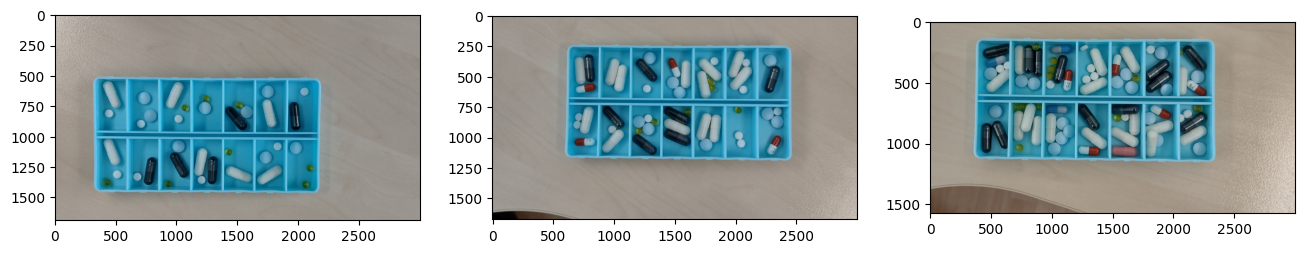

In [177]:
images = ['test1', 'test2', 'test3']
fig, ax = plt.subplots(1, len(images), figsize=(16,9))
for i, img_name in enumerate(images):
    test_img = cv2.imread(f'Data/{img_name}.png')
    ax[i].imshow(test_img[..., ::-1])

/tmp/ipykernel_29257/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


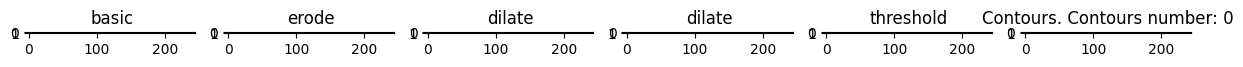

Liczba konturow:  0


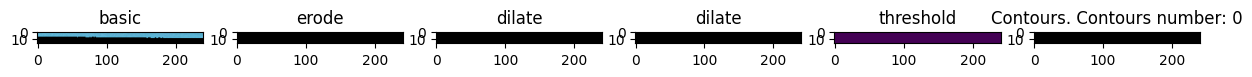

Liczba konturow:  0


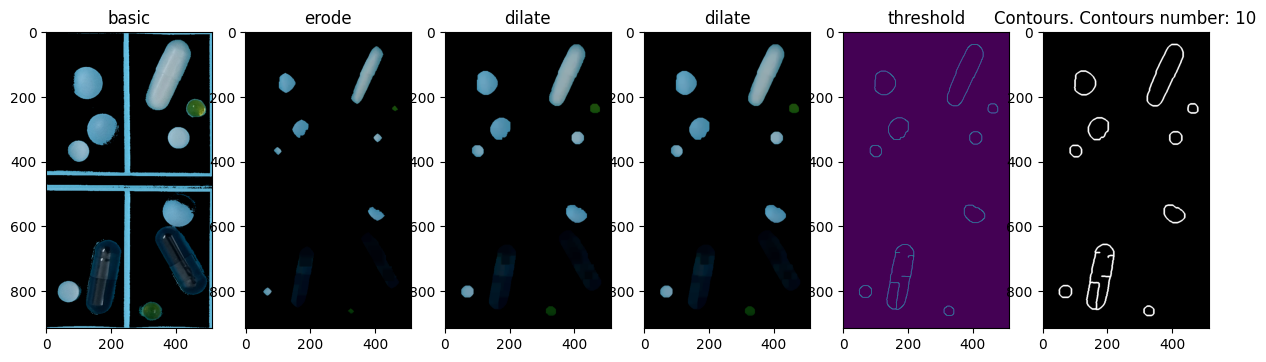

Liczba konturow:  10


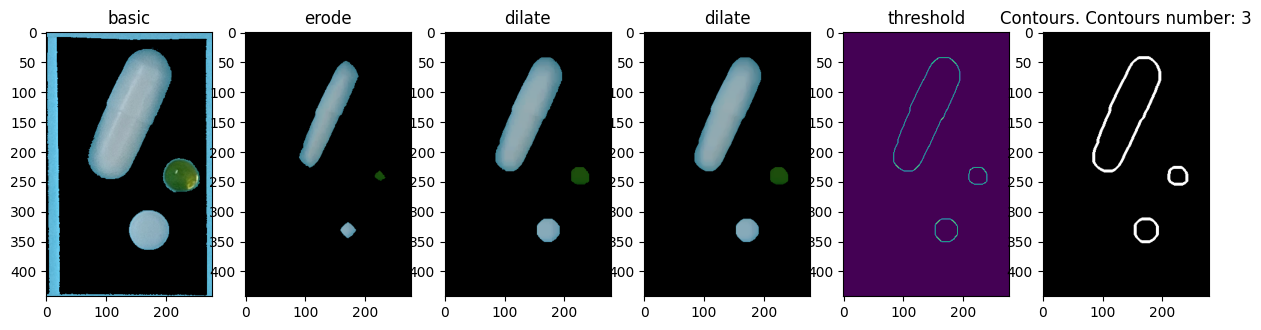

Liczba konturow:  3


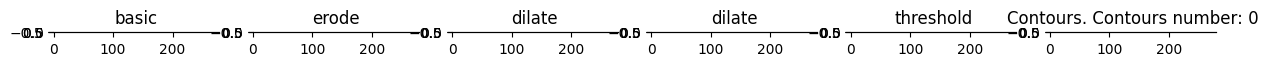

Liczba konturow:  0


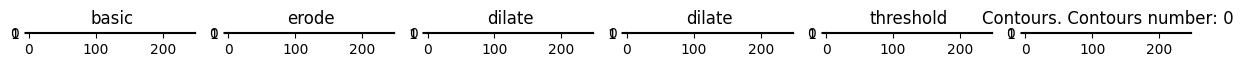

Liczba konturow:  0


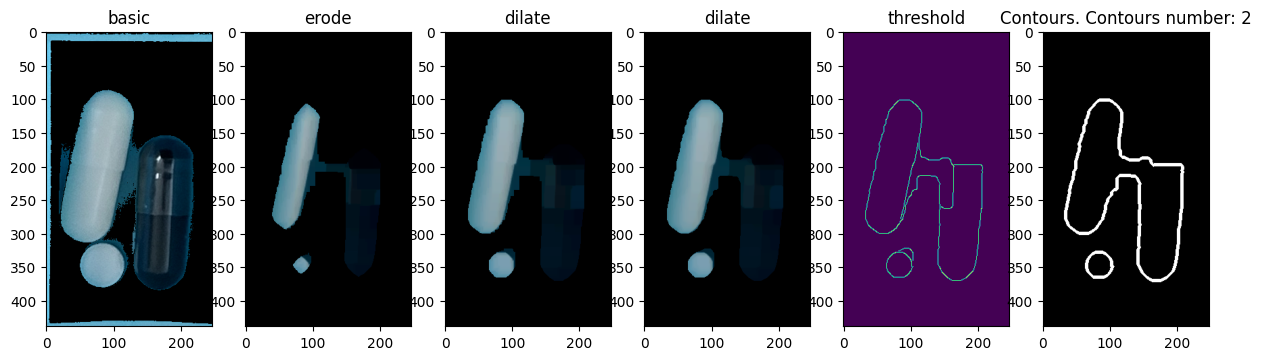

Liczba konturow:  2


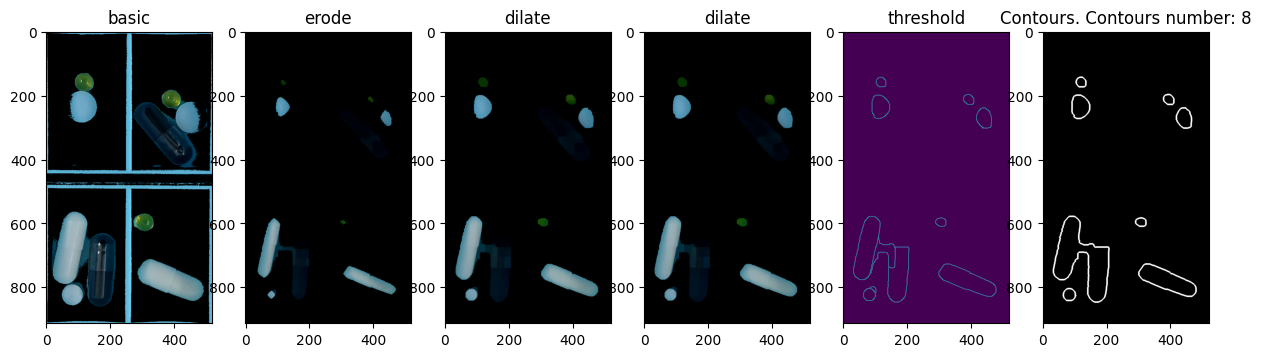

Liczba konturow:  8


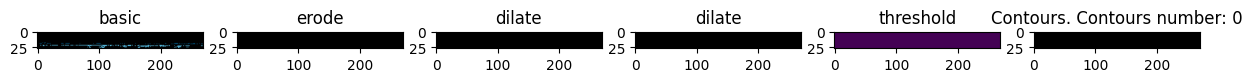

Liczba konturow:  0


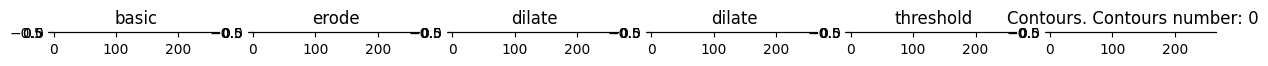

Liczba konturow:  0


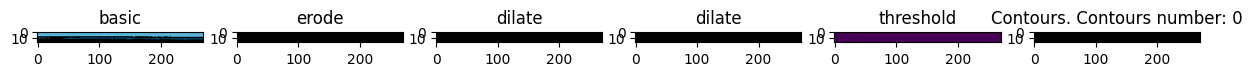

Liczba konturow:  0


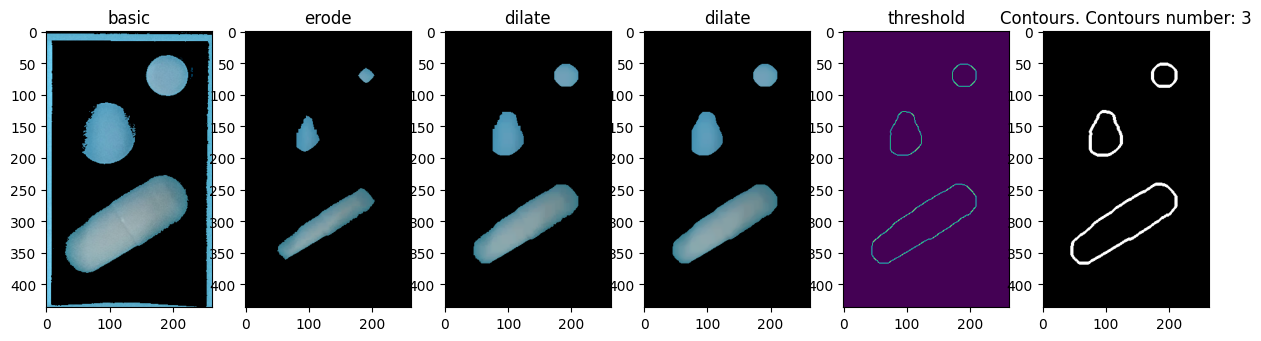

Liczba konturow:  3


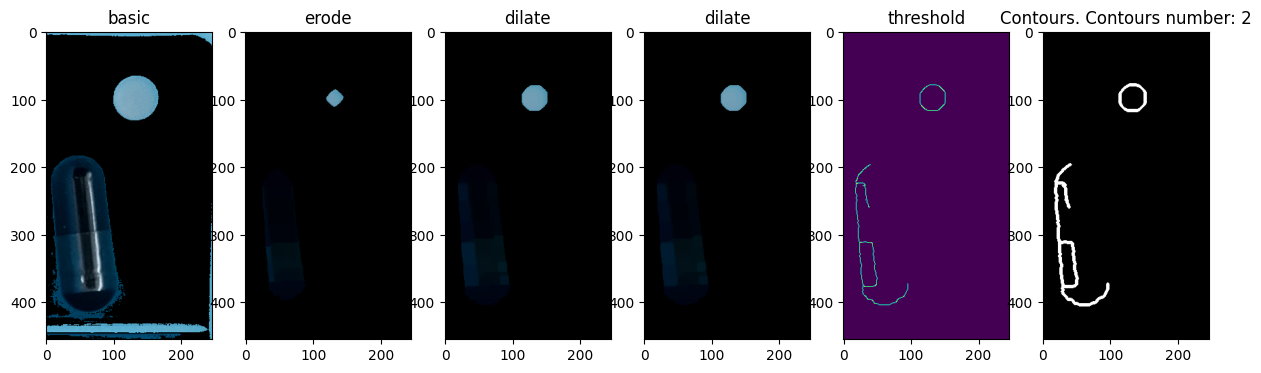

Liczba konturow:  2


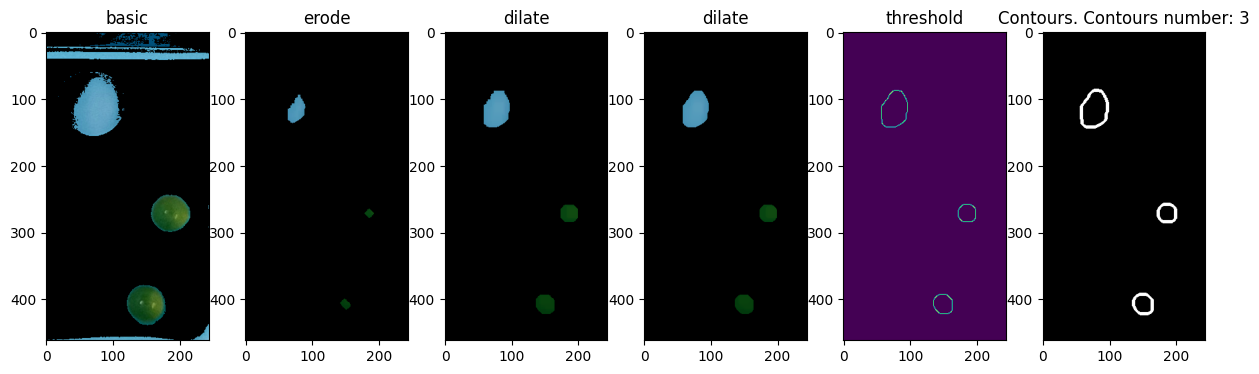

Liczba konturow:  3
928 571 red [ 97.66069032  45.80115053 184.54803452] [ 93  32 154] [101  96 214]
928 571 red [ 97.66069032  45.80115053 184.54803452] [ 93  32 154] [101  96 214]
1155 1113 grey [ 99.057764   110.65247271 120.86937969] [90 12 24] [111 255 255]
1421 1262 grey [ 94.30865801  46.98495671 170.75562771] [ 89  25 141] [ 98 110 194]
1155 1113 grey [ 99.057764   110.65247271 120.86937969] [90 12 24] [111 255 255]
1538 774 blue [ 99.36811594 125.50931677 168.20662526] [ 98 108 150] [100 153 188]
1212 734 blue [ 99.8320862  116.21789883 194.4393894 ] [ 98 106 172] [101 141 208]
1684 1256 grey [ 95.57940625  51.74395762 169.76183644] [ 91  30 137] [ 99 111 198]
1713 1141 blue [ 99.3191568  122.82359467 192.30658284] [ 99 113 174] [100 140 200]
1967 1077 blue [ 99.65879708 126.81000562 195.78583474] [ 99 117 185] [100 146 205]


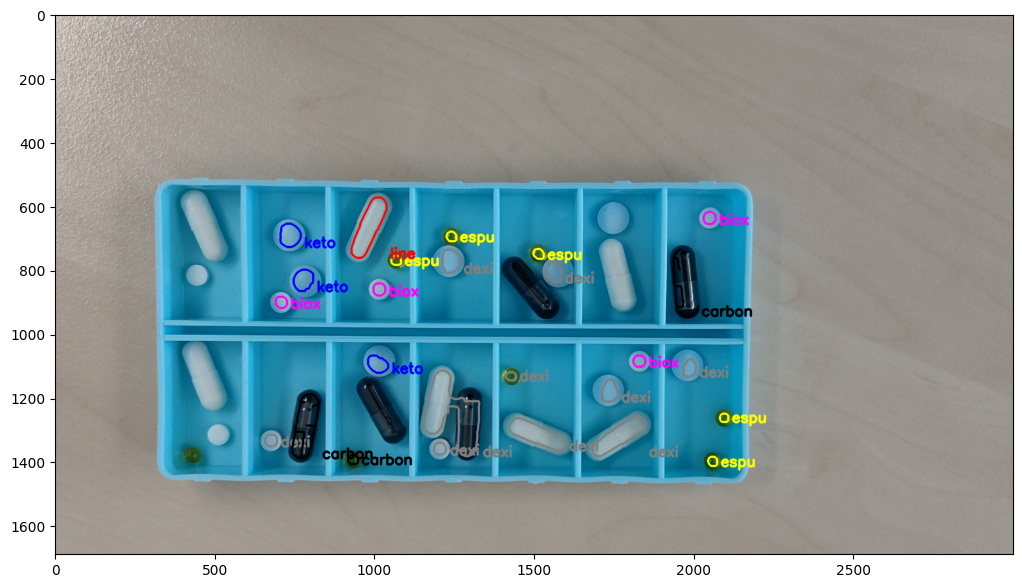

/tmp/ipykernel_29257/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


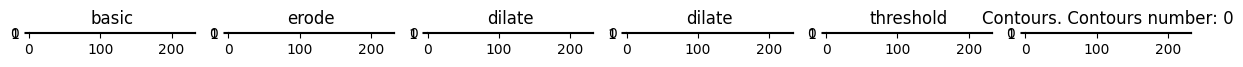

Liczba konturow:  0


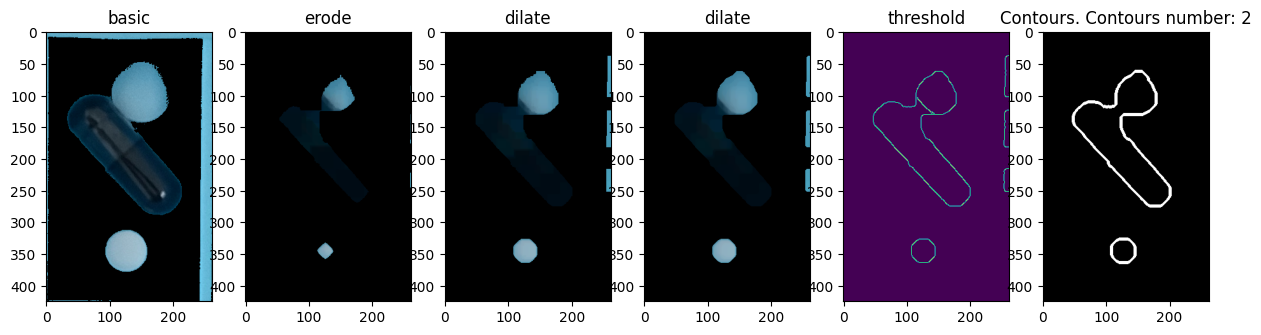

Liczba konturow:  2


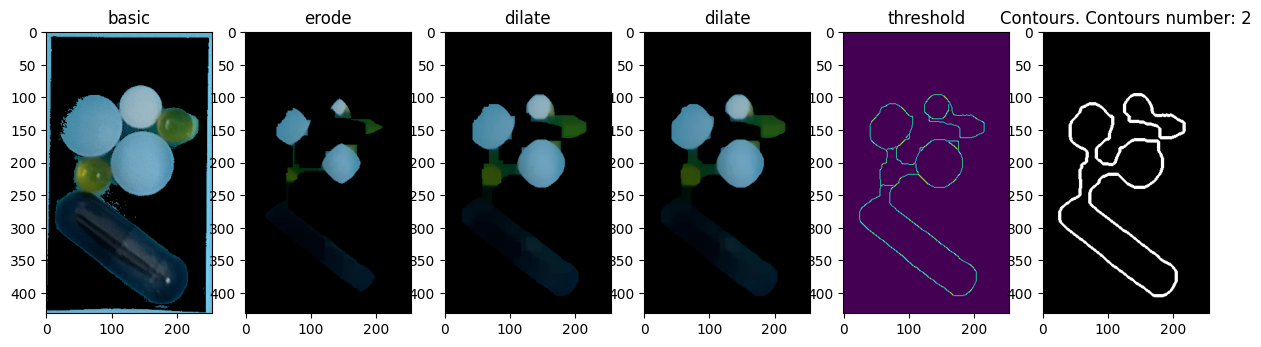

Liczba konturow:  2


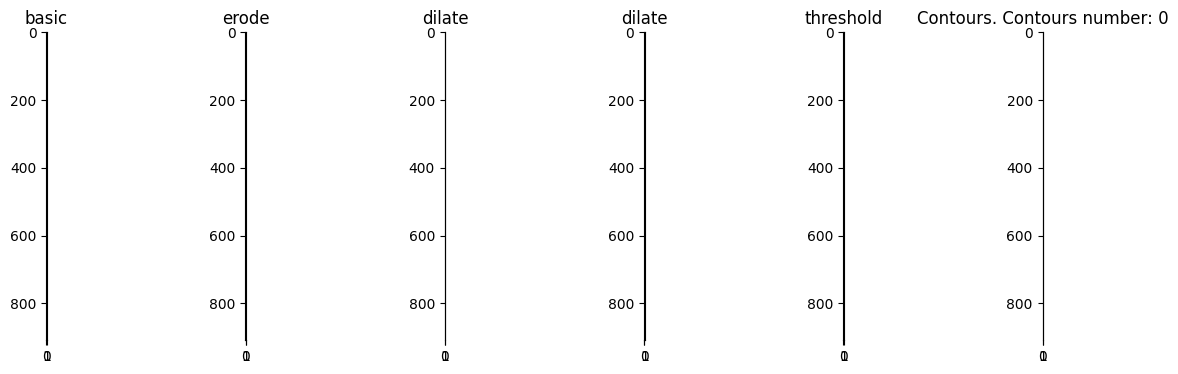

Liczba konturow:  0


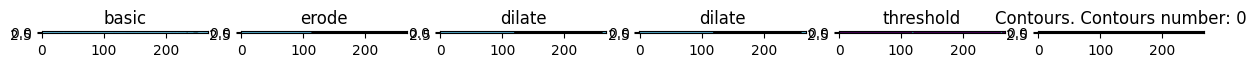

Liczba konturow:  0


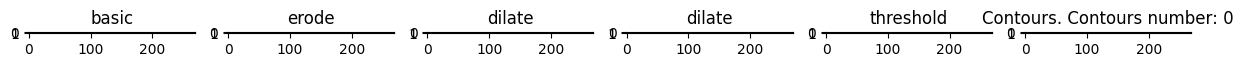

Liczba konturow:  0


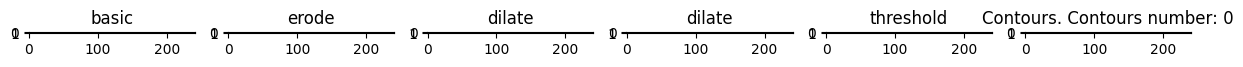

Liczba konturow:  0


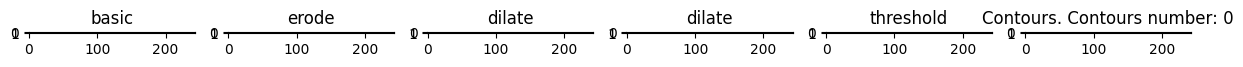

Liczba konturow:  0


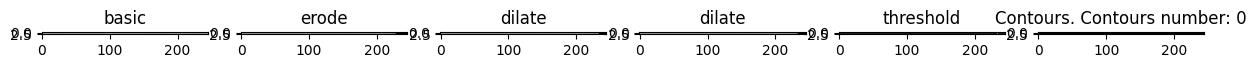

Liczba konturow:  0


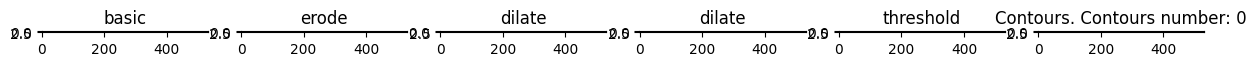

Liczba konturow:  0


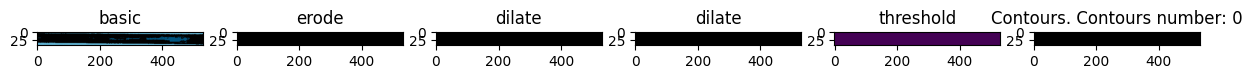

Liczba konturow:  0


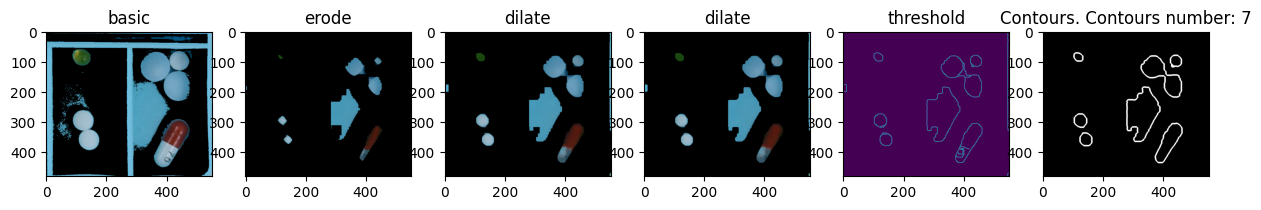

Liczba konturow:  7


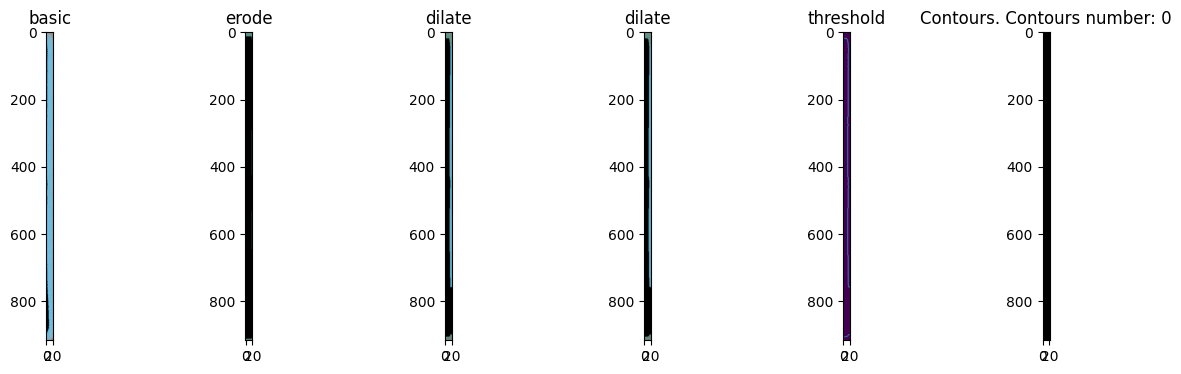

Liczba konturow:  0


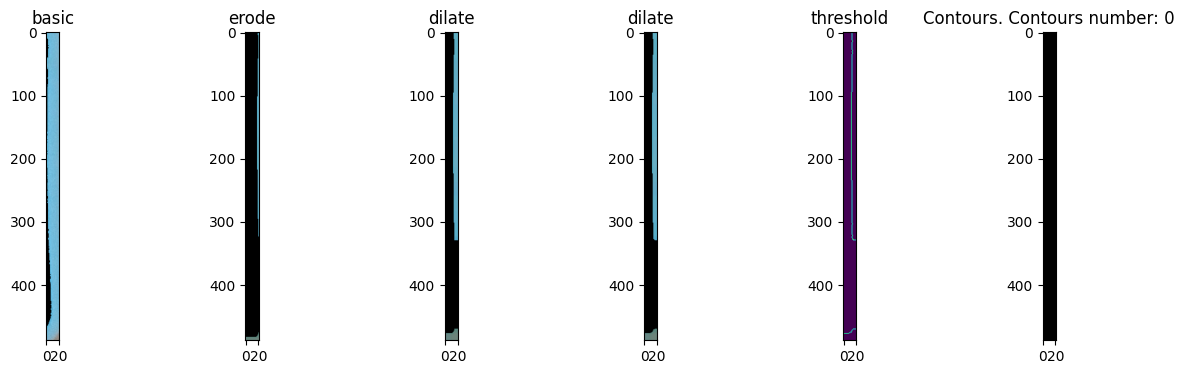

Liczba konturow:  0
1263 829 red [ 76.85108583  96.59462254 150.89796622] [37 41 73] [101 201 201]
2183 879 blue [ 98.01722342 144.05735801 190.87775375] [ 97 119 177] [100 158 225]


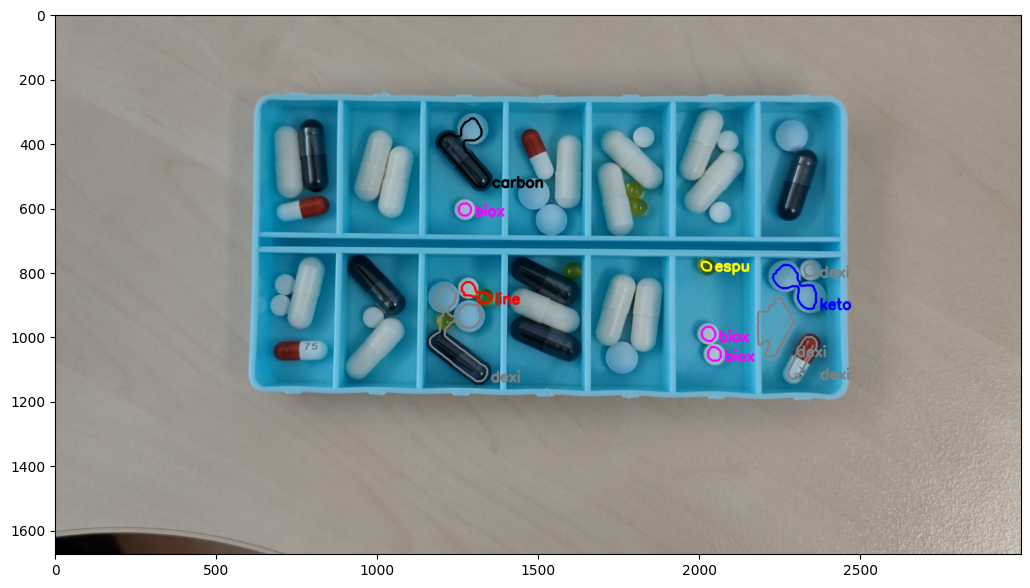

/tmp/ipykernel_29257/2730280017.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0]


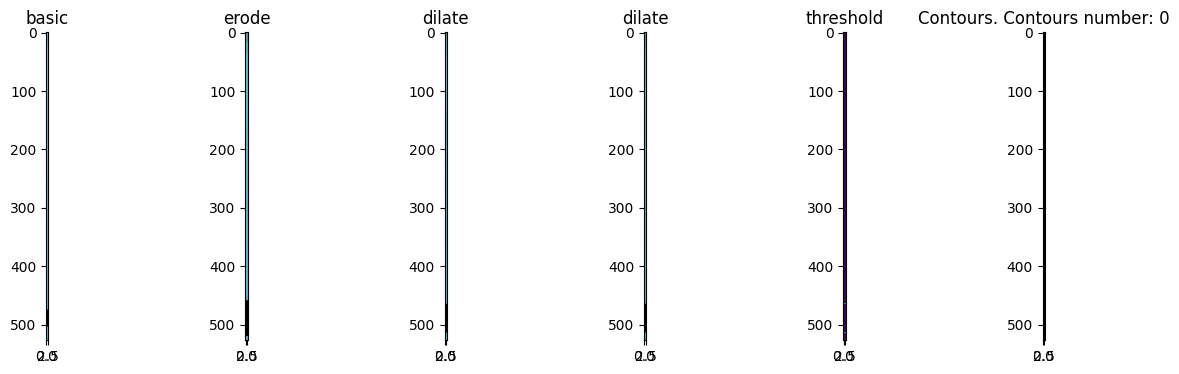

Liczba konturow:  0


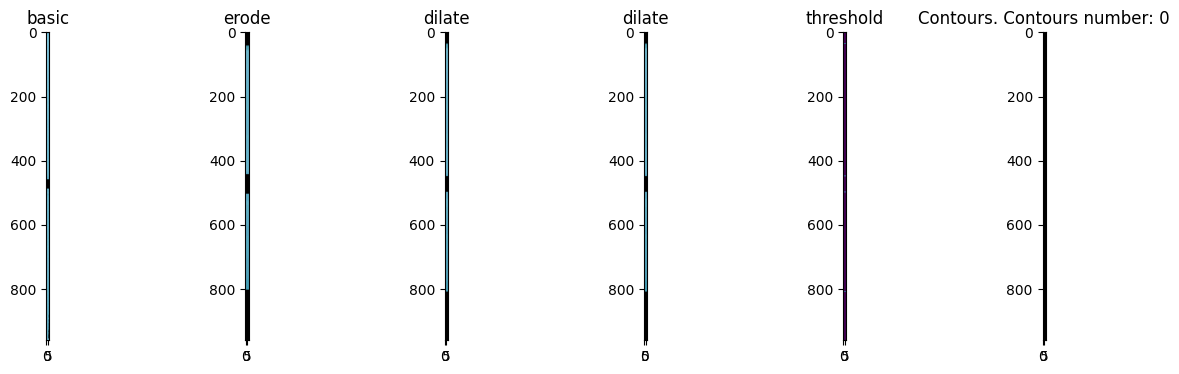

Liczba konturow:  0


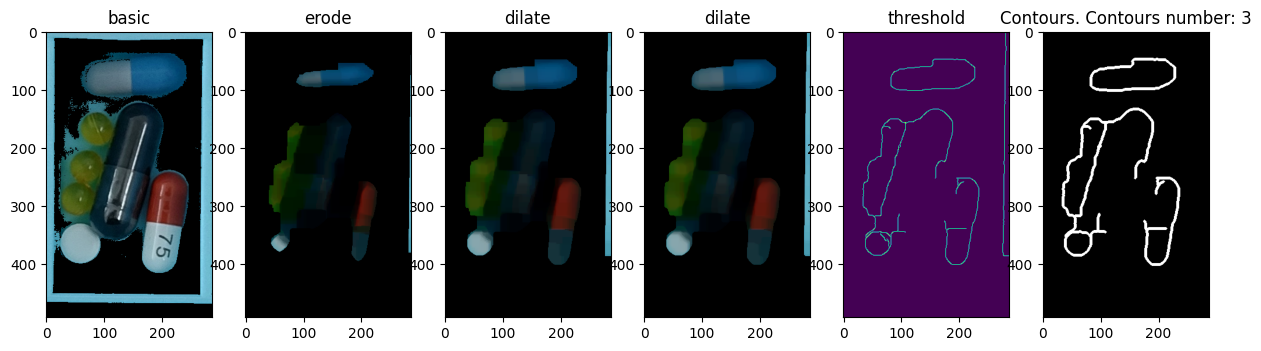

Liczba konturow:  3


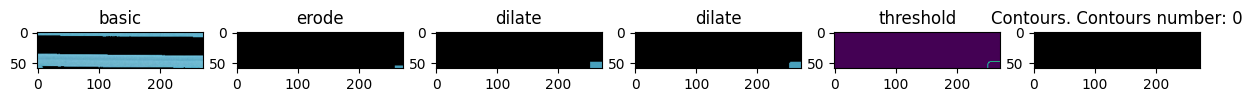

Liczba konturow:  0


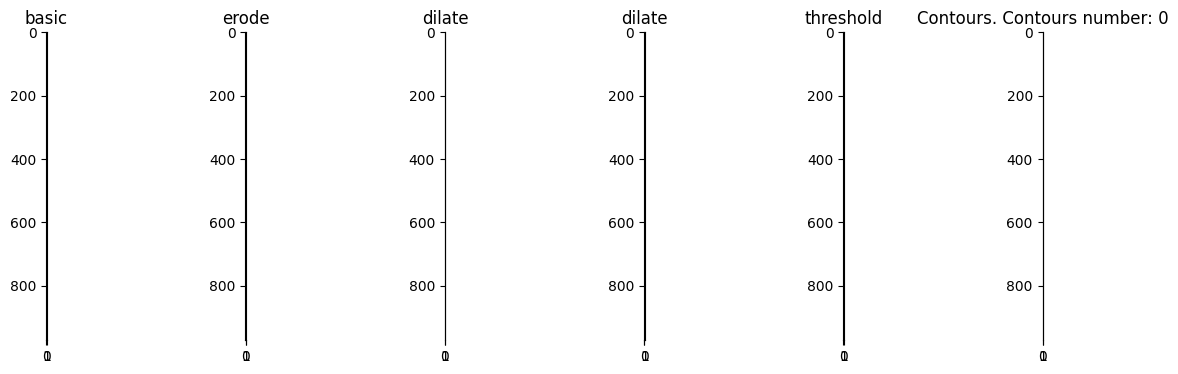

Liczba konturow:  0


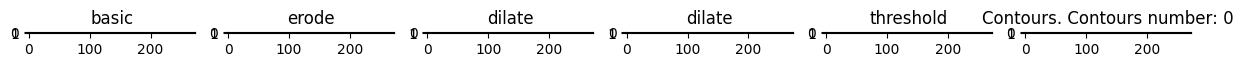

Liczba konturow:  0


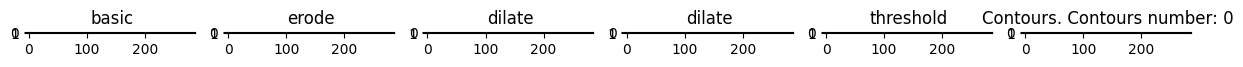

Liczba konturow:  0


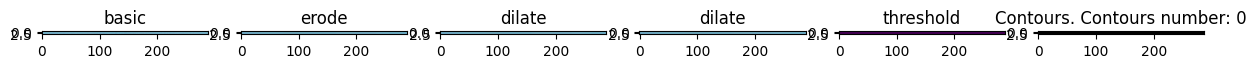

Liczba konturow:  0


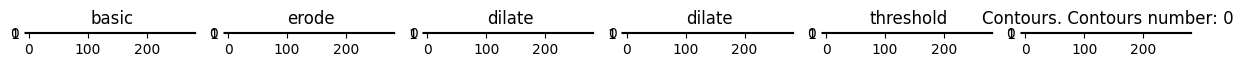

Liczba konturow:  0


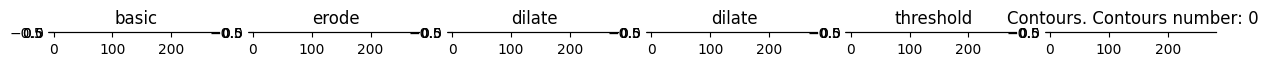

Liczba konturow:  0


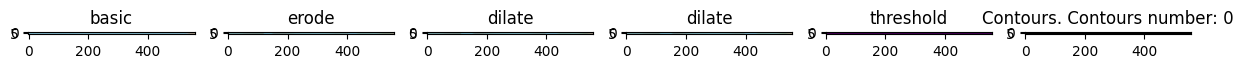

Liczba konturow:  0


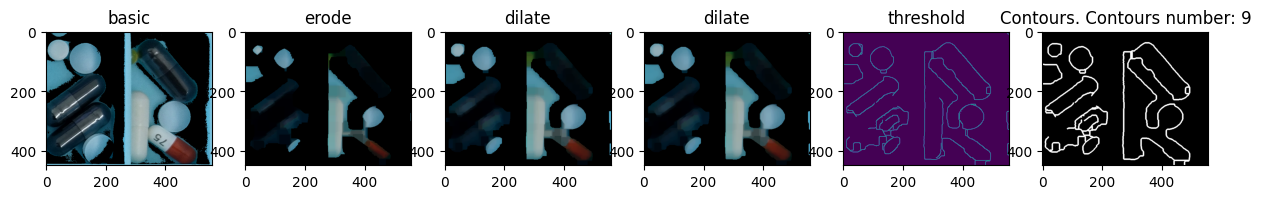

Liczba konturow:  9


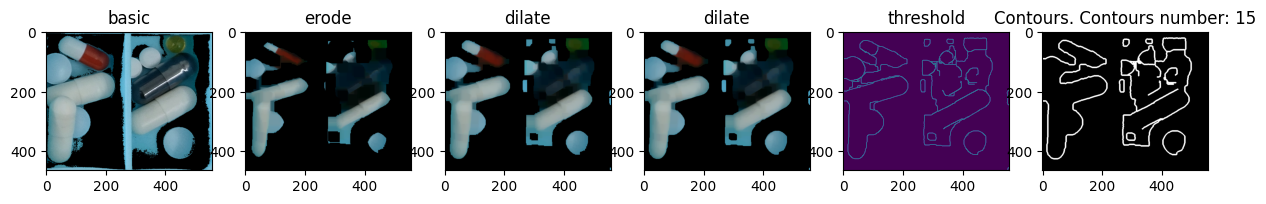

Liczba konturow:  15


ValueError: zero-size array to reduction operation minimum which has no identity

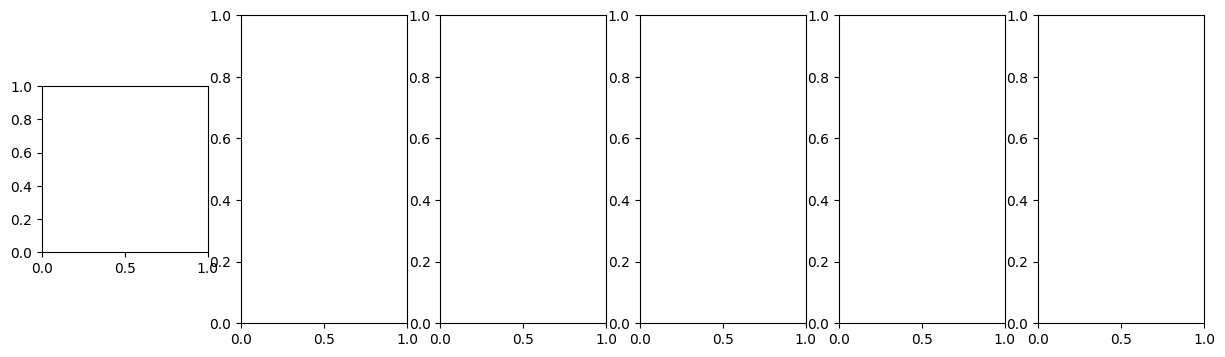

In [178]:
for i, img_name in enumerate(images):
    test_img = cv2.imread(f'Data/{img_name}.png')
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    contours = find_contours_of_pills(test_img, contours_args)
    result = get_recognized_pills(test_img, contours)
    display_recognized(test_img, result)

# miejsce na test - pozostaw wyniki działania oryginalnego algorytmu

In [ ]:
# miejsce na poprawki algorytmu

### Zadanie 4

Wykorzystaj transformację Hougha do wykrycia linii oddzielających poszczególne komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
szczegóły układu tej struktury są dowolne.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.

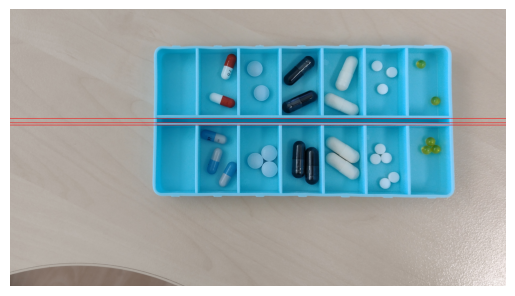

In [45]:
#Detekcja krawędzi metodą Canny'ego - wynik zależy od doboru wartości progów:
img_gray = cv2.cvtColor(calib, cv2.COLOR_BGR2GRAY)
img_canny = cv2.Canny(image=img_gray, threshold1=60, threshold2=120)
Image.fromarray(img_canny)

def rhotheta2xy(line):
    # to samo co w przykładzie tylko w formie funkcji - na potrzeby rysowania
    # zwraca współrzędne odcinka leżącego na pojedynczej linii
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 5000*(-b))
    y1 = int(y0 + 5000*(a))
    x2 = int(x0 - 5000*(-b))
    y2 = int(y0 - 5000*(a))
    return x1, y1, x2, y2

lines = cv2.HoughLines(img_canny, rho=1, theta=np.pi/180, threshold=750)
image_lines = calib.copy()
#Aby narysować wyniki, przechodzimy ze współrzędnych rho-theta na XY
for line in lines:
    x1, y1, x2, y2 = rhotheta2xy(line)
    cv2.line(image_lines, (x1,y1), (x2,y2), (255,0,0), 2)

plt.imshow(image_lines)#Image.fromarray(image_lines)
plt.axis('off')
plt.show()
#ax[i][j].set_title(f'rho: {rho}. threshold: {threshold}')